# Loan Data

## Context
This dataset ([source](https://www.kaggle.com/itssuru/loan-data)) consists of data from almost 10,000 borrowers that took loans - with some paid back and others still in progress. It was extracted from lendingclub.com which is an organization that connects borrowers with investors. We've included a few suggested questions at the end of this template to help you get started.

In [1]:
%%capture
# Load packages
# Import 
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import time
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from collections import Counter
import random
from functools import reduce
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import VectorAssembler , BucketedRandomProjectionLSH
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC, OneVsRest, MultilayerPerceptronClassifier, DecisionTreeClassifier
from pyspark.ml.feature import PCA, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, DoubleType, ArrayType, IntegerType, StringType, LongType
from pyspark.ml.linalg import DenseVector 
from pyspark.sql import Row,DataFrame
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import RFormulaModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import SQLTransformer
# Import necessary functions 
from pyspark.sql.functions import col, when, lit, count as ps_count, mean, stddev, min, max, avg, sum as ps_sum, round, expr, desc,log1p, udf,  rand, array, cast,explode, size, isnan,pandas_udf, PandasUDFType
from pyspark.sql.functions import create_map, struct, concat, substring, lower, row_number
from pyspark.sql.window import *
from pyspark.sql.window import Window

# Others
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# Suppress specific warnings related to Spark's DAGScheduler
warnings.filterwarnings('ignore', category=DeprecationWarning, module='pyspark.broadcast')

cmap=sns.color_palette('Blues_r')




## Load your data

In [2]:
# Set environment variables
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable
# Create a SparkSession
spark = SparkSession.builder \
    .appName("LoanML") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Load your data into a Spark DataFrame
df = spark.read.csv(r"C:\Users\onurh\Downloads\Machine Learning\loan_data.csv", header=True, inferSchema=True)

# Change the dots in the column names to underscores
for cols in df.columns:
    new_col = cols.replace(".", "_")
    df = df.withColumnRenamed(cols, new_col)
# Get the unique values in the 'purpose' column

unique_purposes = df.select("purpose").distinct().rdd.flatMap(lambda x: x).collect()
# Iterate through each unique purpose and create a new column for each
df_p = df.sample(fraction=0.3, seed=0)
for purpose in unique_purposes:
    col_name = "purpose_" + purpose.replace(" ", "_").lower()
    df_p = df_p.withColumn(col_name, expr(f"CASE WHEN purpose = '{purpose}' THEN 1 ELSE 0 END"))

# Print number of rows and columns
print("Number of rows/records:", df_p.count())
print("Number of columns/variables:", len(df_p.columns))

# Show the first few rows of the DataFrame
df_p.limit(5).toPandas() ### Results converted to Pandas data frame for better display

Number of rows/records: 2873
Number of columns/variables: 21


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,delinq_2yrs,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement
0,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,0,0,0,0,0,0,1,0,0,0
1,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,...,0,0,0,0,0,0,0,1,0,0
2,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,...,0,1,1,0,0,0,1,0,0,0
3,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,...,0,0,0,0,0,0,1,0,0,0
4,1,debt_consolidation,0.1347,360.43,10.434116,22.09,677,6713.041667,13846,71.0,...,0,1,0,0,0,0,1,0,0,0


---- 

### 1. Executive summary   
According to a research by BCG, data analytics has been credited as 1 of the biggest drivers behind digital lending. The availability of data coupled with favorable regulatory environment is projected to enable nearly $1 trillion worth of digital loans to be disbursed in India alone in the next 5 years. For a digital lender to be competitive in the market, it must own the appropriate model to make lending decisions. Thus, based on the dataset which contains client credit record and loan history, we propose a model to predict the chances of a non-full payment from the client's loan. We first created a simple logistic regression model using features selected with RFE (and Random Forest and Gradient boosting as the underlying models). However, recall was low at 2% using this approach. Next, ‘stratified k-fold cross validation with SMOTE’ was applied during the model training to overcome issues with an imbalanced class.  Hyper-params were also fine-tuned using GridSearchCV. Recall then improved significantly to 61.2%. As a next step, we recommend researching more complex models like neural network to further improve the model and reduce the credit risk of the lender.


### 2. Business Problem and motivation  

For a digital lender to be profitable, it must not only have data strategy to acquire the data necessary for credit modelling, more importantly, such lenders must possess analytics models which allow it to make both lending decisions and monitor the financial health of its clients. In this report, we will attempt to create a model for digital lenders to make lending decisions based on the client data it has acquired. (McKinsey, 2021)

Our hypothesis is that based on the client's loan history and credit records, the lender will be able to predict the chances of a non-full payment from the client's loan. Such a predict can be further improved by perform vigorous feature selection using the RFE method with an ensemble model. In addition, by further fine tuning the model (by hyper-param tunning, SMOTE, k-fold cross validation), we can further improve the Recall of the model.  


### 3. Exploratory data analysis   
We first check for missing values in the dataset and noticed there is none.

In [3]:
# Train: X 
df_p.limit(5).toPandas() ### Results converted to Pandas data frame for better display.limit(5).toPandas()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,delinq_2yrs,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement
0,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,0,0,0,0,0,0,1,0,0,0
1,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,...,0,0,0,0,0,0,0,1,0,0
2,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,...,0,1,1,0,0,0,1,0,0,0
3,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,...,0,0,0,0,0,0,1,0,0,0
4,1,debt_consolidation,0.1347,360.43,10.434116,22.09,677,6713.041667,13846,71.0,...,0,1,0,0,0,0,1,0,0,0


In [4]:
# Check for missing values
df.printSchema()
df.limit(5).toPandas().info()
missing_counts = df.agg(*[ps_count(col(c)).alias(c) for c in df.columns])
missing_counts.toPandas()

root
 |-- credit_policy: integer (nullable = true)
 |-- purpose: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- log_annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- fico: integer (nullable = true)
 |-- days_with_cr_line: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- not_fully_paid: integer (nullable = true)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      5 non-null      int32  
 1   purpose            5 non-null      object 
 2   int_rate           5 non-null      float64
 3   installment        5 non-null      float64
 4   log

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,9578,9578,9578,9578,9578,9578,9578,9578,9578,9578,9578,9578,9578,9578


In [5]:
# Split col by data type
num = ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
non_num = ['purpose']

Next, we check the distribution of the numerical values to see if there's outliers or skewed distribution.   

### 3.1. Numerical features 

In [6]:
# Check distribution of num values
df_p.select(num).describe().toPandas()

,summary,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
0,count,2873,2873,2873,2873,2873,2873,2873,2873,2873,2873,2873,2873
1,mean,0.8092586146884789,0.12229342151061719,317.2459101983995,10.9324792581166,12.523069961712514,710.9819004524887,4582.936245502666,17143.318830490774,46.45250957187612,1.5266272189349113,0.15001740341106856,0.058127392969021925
2,stddev,0.3929540118753287,0.026725425840838337,206.28078207134445,0.6274608860631743,6.941150839246164,37.94557502444475,2525.423517746956,31682.860095199136,29.16701201417373,2.1642361658720026,0.4765907606940263,0.2413494482877037
3,min,0,0.06,15.67,7.60090246,0.0,612,180.0416667,0,0.0,0,0,0
4,max,1,0.2121,926.83,14.52835448,29.96,827,17639.95833,401941,119.0,32,5,2


=== Distribution of features (before log transformation) ===


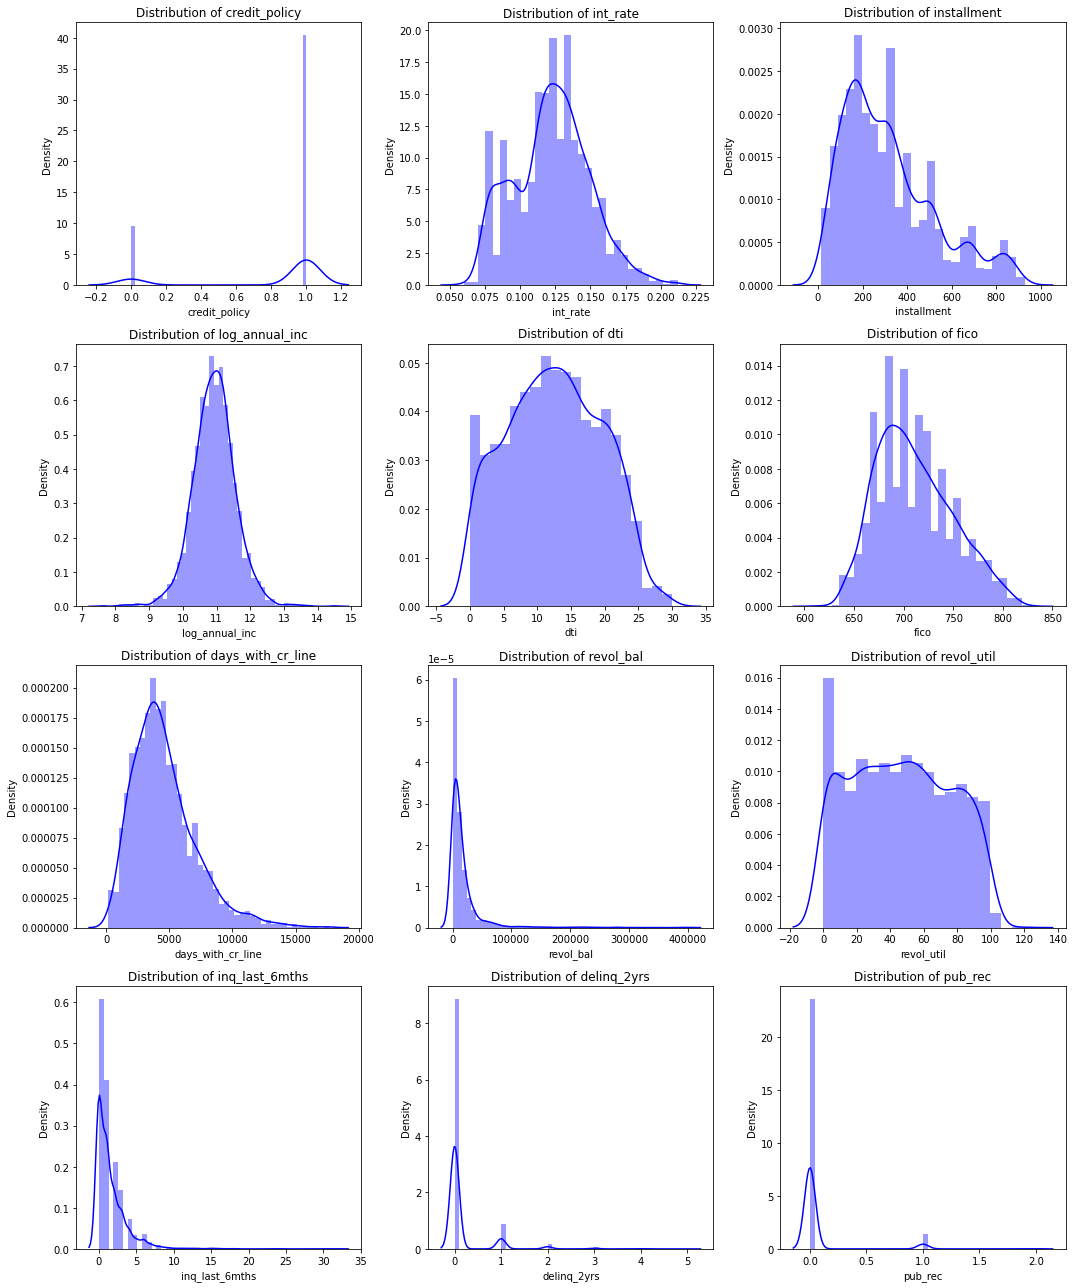

In [7]:
# Check distribution (num)
print(f'=== Distribution of features (before log transformation) ===')
plt.figure(figsize=(15, 18))
num_rows = 4
num_cols = 3

for i, cols in enumerate(num):
    # Plot distribution
    df_to_Pandas = df_p.select(cols).toPandas()
    plt.subplot(num_rows,num_cols,i+1); sns.distplot(df_to_Pandas[cols], color='blue')
    plt.title(f'Distribution of {cols}')
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see that except for `log_annual_inc`, all the other numerical features are highly skewed.   
This can pose a problem when modelling as most machine learning models require features to be normally distributed.
Thus, we will perform log transformation before using these features in our modelling.   


In [8]:
# Display unique values in cat data
df_p.select('purpose').distinct().toPandas()

,purpose
0,all_other
1,educational
2,small_business
3,debt_consolidation
4,credit_card
5,major_purchase
6,home_improvement


In [4]:
# Log transform function
def log_transform(data, to_log):
    X = data
    for cols in to_log:
        X = X.withColumn(cols, log1p(X[cols]))
    return X

# Log transform
to_log = ['credit_policy', 'int_rate', 'installment', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']


In [10]:
df_p_l = log_transform(df_p, to_log)

In [11]:
df_p_l.limit(5).toPandas().head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,delinq_2yrs,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement
0,0.693147,debt_consolidation,0.127249,5.907702,10.373491,2.536075,6.526495,8.457655,8.163941,3.280911,...,0.0,0.000000,0,0,0,0,1,0,0,0
1,0.693147,credit_card,0.075849,4.837313,11.904968,2.889260,6.590301,8.719488,10.835809,3.951244,...,0.0,0.000000,0,0,0,0,0,1,0,0
2,0.693147,debt_consolidation,0.139414,5.273102,10.714418,1.609438,6.504288,8.064964,8.253228,4.354141,...,0.0,0.693147,1,0,0,0,1,0,0,0
3,0.693147,debt_consolidation,0.115202,4.444062,10.203592,2.397895,6.562444,7.912438,8.636042,3.178054,...,0.0,0.000000,0,0,0,0,1,0,0,0
4,0.693147,debt_consolidation,0.126368,5.890068,10.434116,3.139400,6.519147,8.811956,9.535824,4.276666,...,0.0,0.693147,0,0,0,0,1,0,0,0


In [12]:
df_p_l.describe().toPandas()

,summary,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,...,delinq_2yrs,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement
0,count,2873,2873,2873,2873,2873,2873,2873,2873,2873,...,2873,2873,2873,2873,2873,2873,2873,2873,2873,2873
1,mean,0.5609353271151364,None,0.11509126465441746,5.5295983369434465,10.9324792581166,2.4030176922243736,6.566650942979575,8.26723226554511,8.589790116380861,...,0.09217328196803873,0.03979017361338396,0.16324399582318133,0.25304559693699963,0.030978071702053602,0.06160807518273582,0.40863209189001043,0.13435433344935607,0.046641141663766095,0.06474068917507832
2,stddev,0.27237496542110345,None,0.023788645372739663,0.7305760978235584,0.6274608860631743,0.7370344361630321,0.0527935562870149,0.614190952519672,2.218049873271059,...,0.2687597825734943,0.16365128698304485,0.3696524783104735,0.434832537094154,0.1732884383781223,0.2404841989874261,0.4916666004552046,0.34109198479605624,0.2109057326627356,0.24611057469524353
3,min,0.0,all_other,0.058268908123975775,2.813610696762703,7.60090246,0.0,6.418364935936212,5.198727207535667,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,max,0.6931471805599453,small_business,0.19235439249432928,6.832848526349754,14.52835448,3.4326960487215263,6.71901315438526,9.777978655182626,12.904063078585034,...,1.791759469228055,1.0986122886681096,1,1,1,1,1,1,1,1


=== Distribution of features (after log transformation) ===


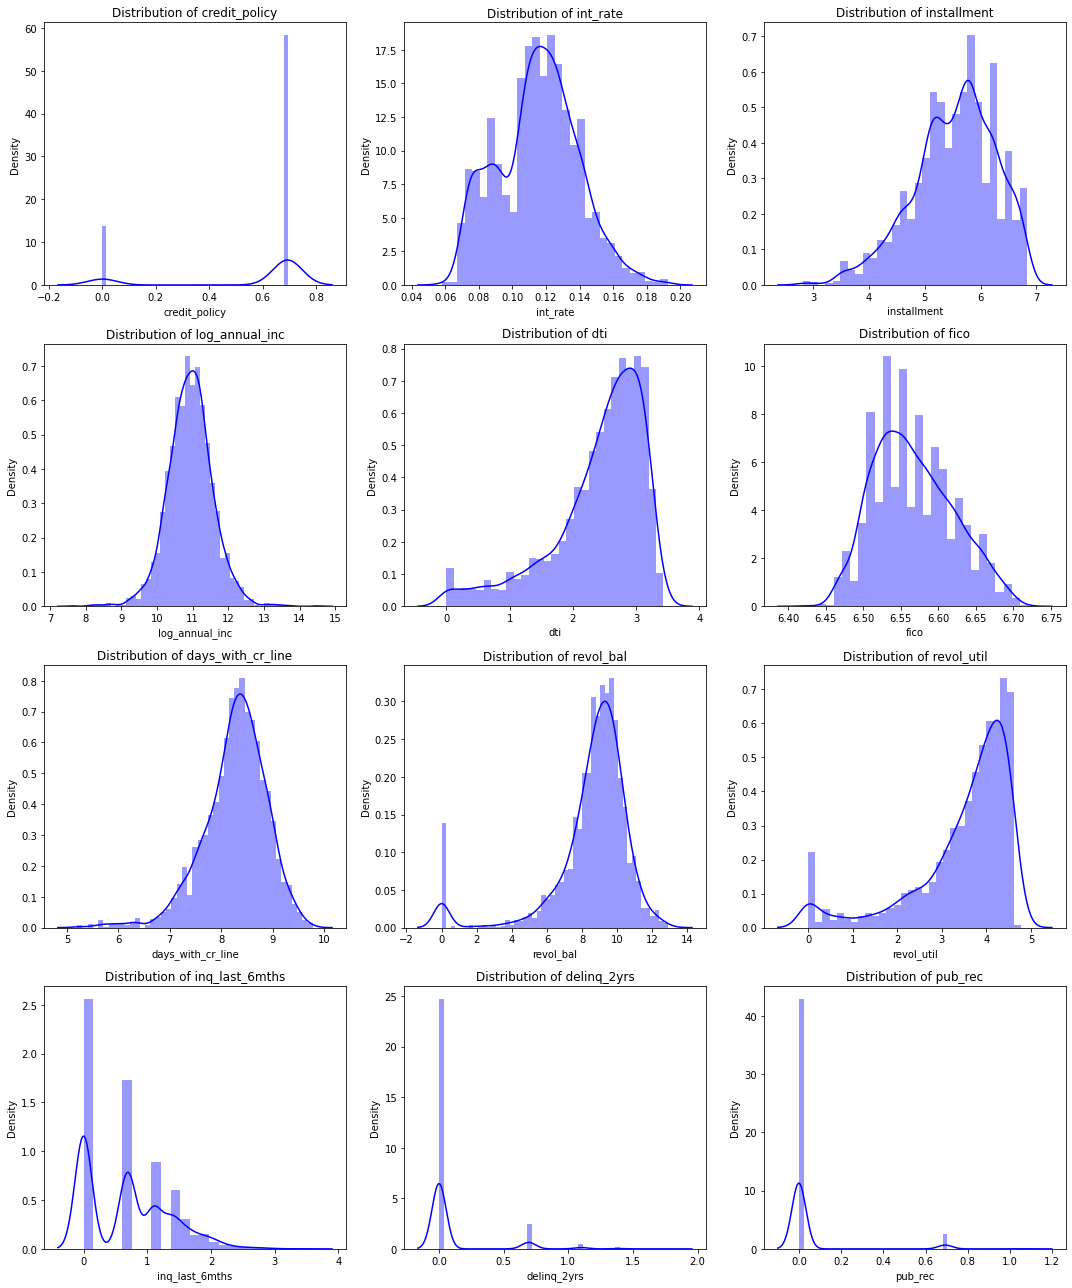

In [13]:
# Check distribution (num)
print(f'=== Distribution of features (after log transformation) ===')
plt.figure(figsize=(15, 18))
num_rows = 4
num_cols = 3

for i, cols in enumerate(num):
    # Plot distribution
    df_p_l_to_Pandas = df_p_l.select(cols).toPandas()
    plt.subplot(num_rows,num_cols,i+1); sns.distplot(df_p_l_to_Pandas[cols], color='blue')
    plt.title(f'Distribution of {cols}')
# Show the plot
plt.tight_layout()
plt.show()

Now that log transformation is done, we check the distribution of the numerical features again.   
In general, the distributions have improved and are no longer as skewed as before.   
However, we noticed that each feature is on a different scale.   
e.g. `log_annual_inc` is on a much larger scale and might unnecessarily scale our models.   
Thus, we will proceed next to normalize the features before modelling.  


### 3.2 Categorial features 

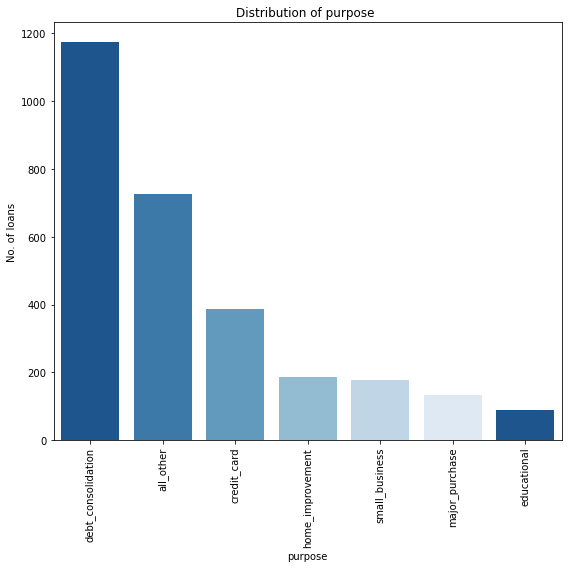

In [14]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, cols in enumerate(['purpose']):
    order = df_p_l.groupBy(cols).count().orderBy("count", ascending=False).toPandas()[cols].tolist()  
    plt.subplot(1,1,i+1); sns.countplot(x=cols,data=df_p_l.select(cols).toPandas(),palette=cmap, order = order ) 
    plt.title(f'Distribution of purpose ')
    plt.ylabel('No. of loans')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see that the largest purpose for a loan is debt consolidation and other purposes.   
Education is the least reason for a loan in this dataset. We will keep this in view to see how it might impact our modelling later. 

In [15]:
df_p_l.select('purpose').toPandas().describe()

,purpose
count,2873
unique,7
top,debt_consolidation
freq,1174


### 3.3. Target variable  

In this section, we analyze the distribution target feature in detail and examine if there's any point for concern before moving on to modelling.  


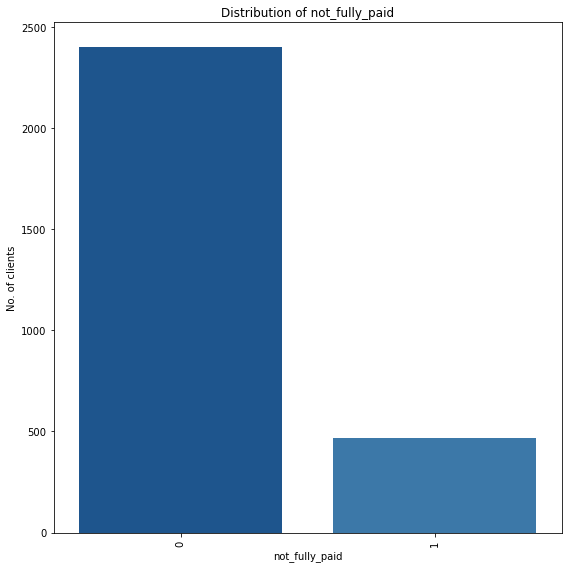

In [16]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, cols in enumerate(['not_fully_paid']):
    order = df_p_l.groupBy(cols).count().orderBy("count", ascending=False).toPandas()[cols].tolist()  
    plt.subplot(1,1,i+1); sns.countplot(x=cols,data=df_p_l.select(cols).toPandas(),palette=cmap, order = order )  
    plt.title(f'Distribution of {cols}')
    plt.ylabel('No. of clients')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see huge class imbalance in the target variable. i.e., Only approximately 15% of the loans are not fully paid.    
Thus, we must take care of this in the modelling (e.g., apply re-sampling technique) and ensure that huge class imbalance do not negatively impact our modelling performance.   

At this juncture, we argue that recall is the most important performance metric for our modelling purpose.  
This is because if a loan is not fully paid, the lender will incur high default risk. Thus, it is more important to have a good recall (low FN) instead of a high precision (low FP). In cases of FN, the lender will lose huge amount of capital due to default and this is highly undesirable. On the other hand, in cases of FP, the lender loses only potential revenue (at the expense of lower default risk) which we believe is comparatively acceptable.  


In [17]:
def stack_bar(d, xlabel, hue='not_fully_paid'):
    plt.figure(figsize=(5, 5))
    
    # Group by xlabel and hue, then calculate the percentage of each category in hue
    total_count = d.groupBy(xlabel).count().alias('total_count')
    count_by_group = d.groupBy([xlabel, hue]).count().alias('count_by_group')
    pct_expr = (count_by_group['count'] / total_count['count']).alias('percentage')
    train_pct = total_count.join(count_by_group, xlabel, 'left').select(xlabel, hue, pct_expr)
    
    # Pivot the DataFrame to have 'hue' as columns
    pivoted_df = train_pct.groupBy(xlabel).pivot(hue).avg('percentage').fillna(0)
    
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    pd_df = pivoted_df.toPandas()
    
    # Set the index to the values of xlabel
    pd_df.set_index(xlabel, inplace=True)
    pd_df = pd_df.sort_index()
    
    # Plot stacked bar chart
    pd_df.plot(kind='bar', stacked=True)
    plt.ylabel('%')
    plt.title(f'100% stack bar chart \n By {xlabel}')
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    plt.legend(title=hue)
    plt.show()


<Figure size 360x360 with 0 Axes>

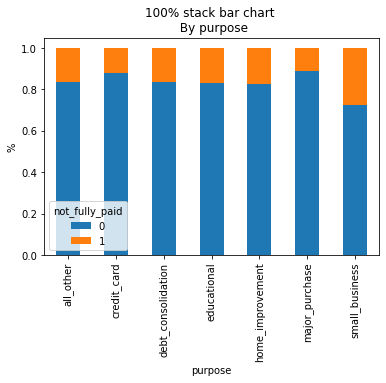

In [18]:
stack_bar(df_p_l, 'purpose', 'not_fully_paid')

From the chart above, small business and educational loan has the highest proportion of `not fully paid` loans.  
This is likely the case since such small businesses are more susceptible to volatile market and environment situations, resulting in higher chance of defaults.


In [19]:
# Convert target variable to a categorical variable
train = df_p_l.withColumn('y', when(df_p_l['not_fully_paid'] == 1, 'yes').otherwise('no'))

# Check the schema to verify the new column
train.limit(5).toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               5 non-null      float64
 1   purpose                     5 non-null      object 
 2   int_rate                    5 non-null      float64
 3   installment                 5 non-null      float64
 4   log_annual_inc              5 non-null      float64
 5   dti                         5 non-null      float64
 6   fico                        5 non-null      float64
 7   days_with_cr_line           5 non-null      float64
 8   revol_bal                   5 non-null      float64
 9   revol_util                  5 non-null      float64
 10  inq_last_6mths              5 non-null      float64
 11  delinq_2yrs                 5 non-null      float64
 12  pub_rec                     5 non-null      float64
 13  not_fully_paid              5 non-null 

In [20]:
# Not fully paid 
train.filter(train['y'] == 'yes').describe().toPandas()

,summary,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,...,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement,y
0,count,469,469,469,469,469,469,469,469,469,...,469,469,469,469,469,469,469,469,469,469
1,mean,0.46111283653454876,None,0.12457941736269021,5.577102659779945,10.870522885375271,2.503429155389853,6.548664576492306,8.218826128957614,8.613703792918201,...,0.050500612312781475,1.0,0.255863539445629,0.031982942430703626,0.1044776119402985,0.4072494669509595,0.10021321961620469,0.031982942430703626,0.06823027718550106,None
2,stddev,0.32744867420129686,None,0.02220123486046839,0.7779802239111334,0.6874558940838676,0.7079158171433123,0.04733963282514939,0.6723039901915251,2.40984079273331,...,0.18554519514324974,0.0,0.43681142459300093,0.17614252110891812,0.30620574689839053,0.49184666807676913,0.3006047276798899,0.17614252110891798,0.2524098854599685,None
3,min,0.0,all_other,0.06812582904760042,2.827905162910489,7.60090246,0.0,6.4425401664681985,5.480465297019814,0.0,...,0.0,1,0,0,0,0,0,0,0,yes
4,max,0.6931471805599453,small_business,0.19235439249432928,6.832848526349754,13.45883561,3.4326960487215263,6.688354713946762,9.66097003203872,12.904063078585034,...,1.0986122886681096,1,1,1,1,1,1,1,1,yes


In [21]:
# fully paid 
train.filter(train['y'] == 'no').describe().toPandas()

,summary,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,...,pub_rec,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement,y
0,count,2404,2404,2404,2404,2404,2404,2404,2404,2404,...,2404,2404,2404,2404,2404,2404,2404,2404,2404,2404
1,mean,0.5804098479480454,None,0.11324020657613929,5.520330646672927,10.94456642068553,2.3834282678380974,6.57015993045152,8.276675892025798,8.585124761016438,...,0.03770065791038167,0.0,0.25249584026622296,0.030782029950083195,0.05324459234608985,0.4089018302828619,0.14101497504159735,0.049500831946755405,0.06405990016638935,None
2,stddev,0.2558536459565767,None,0.023650687948372273,0.7207702784776506,0.61450110936623,0.7411399773010158,0.053096340189976006,0.6018974628319255,2.17917317424171,...,0.15898793812712173,0.0,0.43453450392972487,0.17276258884109388,0.2245675477716039,0.4917333693647342,0.34810940747975233,0.21695639995926808,0.24491055496053307,None
3,min,0.0,all_other,0.058268908123975775,2.813610696762703,8.101677747,0.0,6.418364935936212,5.198727207535667,0.0,...,0.0,0,0,0,0,0,0,0,0,no
4,max,0.6931471805599453,small_business,0.19235439249432928,6.822142922906215,14.52835448,3.4255647381104497,6.71901315438526,9.777978655182626,12.884380262393456,...,1.0986122886681096,0,1,1,1,1,1,1,1,no


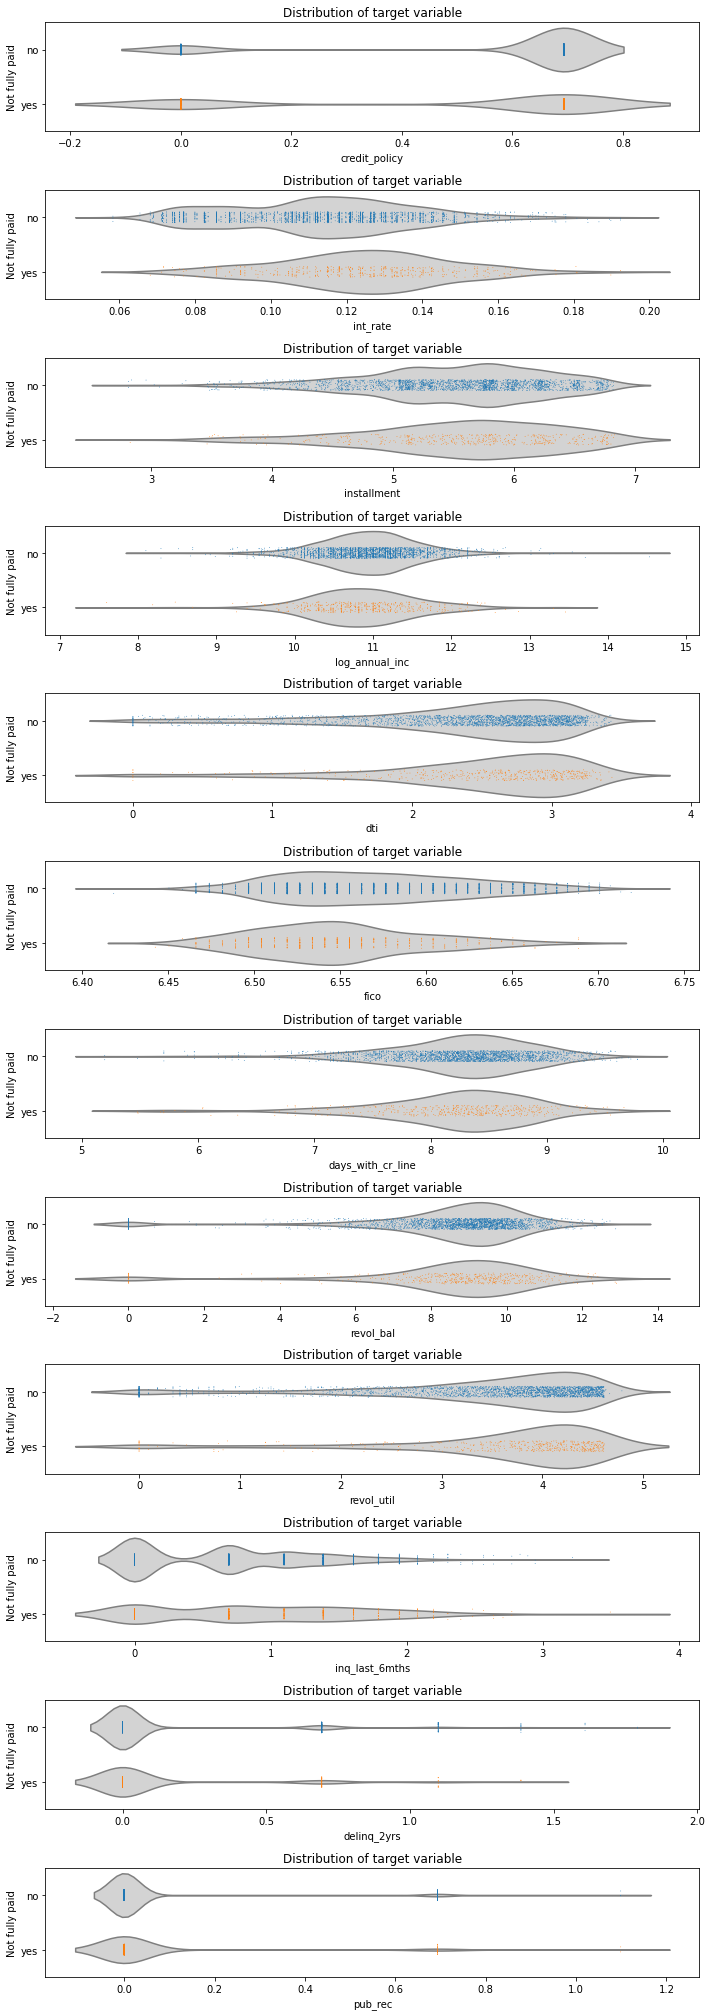

In [22]:
def plot_distribution(train, num):
    pd_train = train.toPandas()
    plt.figure(figsize=(10, 30))
    for i, cols in enumerate(num):
        plt.subplot(13,1,1+i)
        sns.violinplot(x=cols, y='y', data=pd_train, inner=None, color='lightgray')
        sns.stripplot(x=cols, y='y', data=pd_train, size=0.8, jitter=True)
        plt.title('Distribution of target variable')
        plt.ylabel('Not fully paid')
    plt.tight_layout()
    plt.show()

# Call the function
plot_distribution(train, num)

In [23]:
# Plot tsne scatter plot
def tsne_scatterplot(data, hue):
    # Color the points 
    sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2", hue=hue, data=data, alpha=0.3)
    plt.title(hue)

In [24]:
# Assemble all features into a single vector
categorical_cols = ['purpose']
feature_list = ['credit_policy',
 'int_rate',
 'installment',
 'log_annual_inc',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec',
 'purpose_all_other',
 'purpose_educational',
 'purpose_small_business',
 'purpose_debt_consolidation',
 'purpose_credit_card',
 'purpose_major_purchase',
 'purpose_home_improvement']

assembler =  VectorAssembler(inputCols=feature_list,
                                          outputCol="features")

df_p_l_f = assembler.transform(df_p_l).drop(*categorical_cols)
# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_p_l_f)
X_train_scaled = scaler_model.transform(df_p_l_f)

# Convert Spark DataFrame to pandas DataFrame for t-SNE
X_train_scaled_pd = X_train_scaled.select(num + ["scaled_features"]).toPandas()
# Extract scaled features from pandas DataFrame
X_train_scaled_array = X_train_scaled_pd["scaled_features"].apply(lambda x: x.toArray()).tolist()
# Convert the scaled features list to a NumPy array
X_train_scaled_array_np = np.array(X_train_scaled_array)

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(X_train_scaled_array_np)

# Prepare data for plotting
df_tsne = df_p.toPandas()
df_tsne['t_SNE_PC_1'] = tsne_features[:,0]
df_tsne['t_SNE_PC_2'] = tsne_features[:,1]
df_tsne.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,...,not_fully_paid,purpose_all_other,purpose_educational,purpose_small_business,purpose_debt_consolidation,purpose_credit_card,purpose_major_purchase,purpose_home_improvement,t_SNE_PC_1,t_SNE_PC_2
0,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,0,0,0,0,1,0,0,0,12.323844,-27.209173
1,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,...,0,0,0,0,0,1,0,0,-4.369326,57.239132
2,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,...,1,0,0,0,1,0,0,0,33.618736,23.639135
3,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,...,0,0,0,0,1,0,0,0,7.011994,-16.852942
4,1,debt_consolidation,0.1347,360.43,10.434116,22.09,677,6713.041667,13846,71.0,...,0,0,0,0,1,0,0,0,33.703735,26.668467


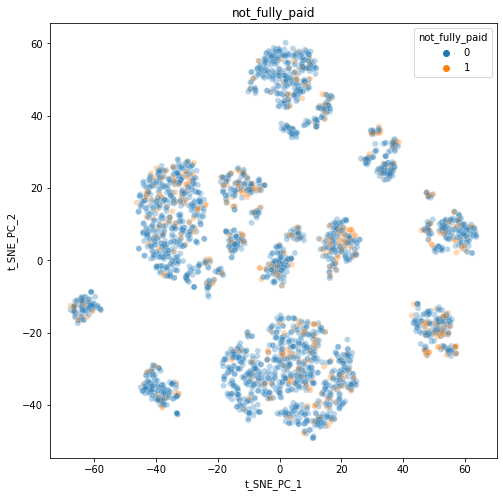

In [25]:
# Viz of y
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'not_fully_paid')
# Plot
plt.show()

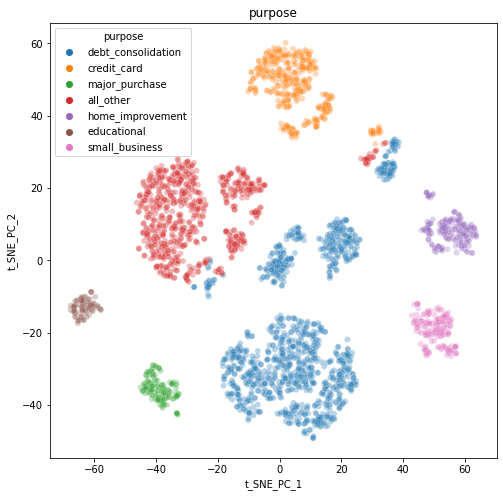

In [26]:
# Viz of purpose
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'purpose')
# Plot
plt.show()

Regretfully, we do not see distinct clusters for the loans which are fully paid vs those which are not.
Additionally, there is no distinct clusters seen for purpose of the loan too.

### 4. Feature selection   

In this section, we first determine the number of features required for modelling purpose using PCA analysis.      
Next, we will use Recursive feature elimination (RFE) to determine the features to use for modelling.   
RFE is a greedy algorithm which recursively remove features and build new models on the remaining features. Based on the model(s) accuracy, it then identifies relevant features which contributed most to predicting the target variable. (Data camp, 2020)



### 4.1 Number of features to use - PCA analysis 
With PCA, we first gain an intuition on the number of features required to explain the variance in all candidate features. PCA was chosen because it can perform dimensionality reduction and remove multi-collinearity at the same time.

In [27]:
# Define the number of principal components to retain
num_components = 18

# Create a PCA instance
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")

# Fit PCA to the training data
pca_model = pca.fit(X_train_scaled)

# Apply the PCA model to transform the data
pca_result = pca_model.transform(X_train_scaled)

# Show the PCA result
pca_result.select("pca_features").show(truncate=True)

# Explained variance ratio
explained_variance_ratio = pca_model.explainedVariance
print("Explained Variance Ratio:", explained_variance_ratio)



+--------------------+
|        pca_features|
+--------------------+
|[0.78277311775826...|
|[-0.1673815229100...|
|[1.27595876550073...|
|[-0.1983611178076...|
|[2.20779687464699...|
|[-0.3500702835073...|
|[-0.9524759756886...|
|[-0.4155177839096...|
|[1.01383090193157...|
|[-0.9550990365869...|
|[1.32620187856315...|
|[-4.1876724595299...|
|[-3.1251776909729...|
|[-0.7247313432467...|
|[-3.2113964109269...|
|[0.27557273514553...|
|[-1.4304415856298...|
|[-4.3470009935234...|
|[-1.7085205040423...|
|[-3.0658921138497...|
+--------------------+
only showing top 20 rows

Explained Variance Ratio: [0.1542113296059215,0.12420882029684864,0.08470198875576213,0.07388366862571787,0.06301575276619496,0.06202080898012622,0.05756187214446975,0.054519661364282844,0.052621438527531206,0.05147695001084864,0.050539043249662526,0.0438600651906975,0.03436831664335777,0.02615588065560948,0.02584047135176004,0.022696102576590455,0.01026473566926995,0.008053093585348657]


In [28]:
# Obtain the explained variance ratio
explained_variance_ratio = pca_model.explainedVariance.toArray()
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [29]:
# cumulative_explained_variance
pca_result.printSchema()

root
 |-- credit_policy: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- log_annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- fico: double (nullable = true)
 |-- days_with_cr_line: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- not_fully_paid: integer (nullable = true)
 |-- purpose_all_other: integer (nullable = false)
 |-- purpose_educational: integer (nullable = false)
 |-- purpose_small_business: integer (nullable = false)
 |-- purpose_debt_consolidation: integer (nullable = false)
 |-- purpose_credit_card: integer (nullable = false)
 |-- purpose_major_purchase: integer (nullable = false)
 |-- purpose_home_improvement: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_feat

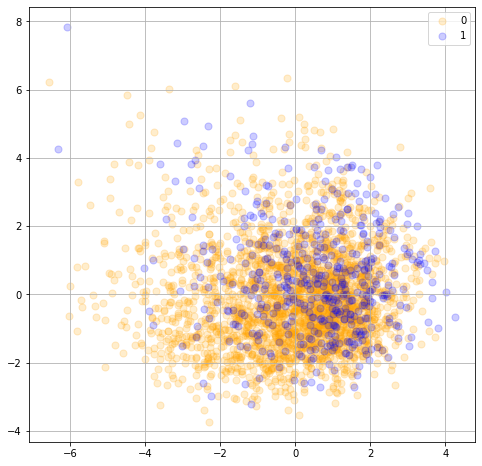

In [30]:
# Plot the principal components from df_PCA
targets = [0, 1]
colors = ['orange', 'blue']

fig, ax = plt.subplots(figsize=(8, 8))

for target, color in zip(targets, colors):
    # Filter the data for the current target
    filtered_data = pca_result.filter(pca_result['not_fully_paid'] == target)
    
    # Extract PCA_1 and PCA_2 values
    pca_values = filtered_data.select('pca_features').rdd.map(lambda row: (row.pca_features[0], row.pca_features[1])).collect()
    pca_1_values, pca_2_values = zip(*pca_values)
    
    # Plot the data points
    ax.scatter(pca_1_values,
               pca_2_values,
               c=color,
               s=50,
               alpha=0.2)

ax.legend(targets)
ax.grid()
plt.show()

From the PCA plot, we can see distinct clusters between loans fully paid (orange) vs loans which are not (blue).      
We will study next the number of features required to explain the variance in the dataset to gain an intuition of the number of features required for our modelling purpose.  

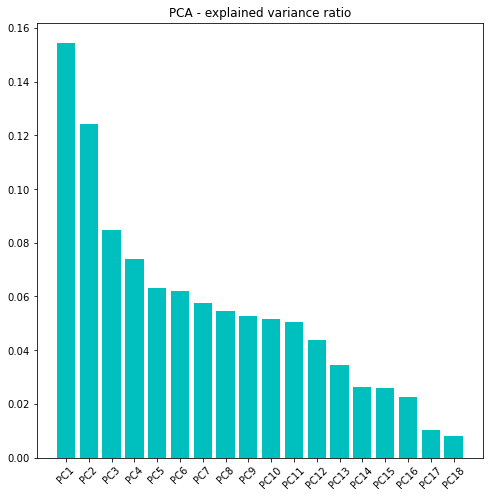

In [31]:
# # Create a Spark DataFrame

# Apply the PCA model to transform the data
variance_explained = pca_model.explainedVariance.toArray()
# Convert explained variance ratio to a list of floats
variance_explained_float = [float(x) for x in variance_explained]

# Create a list of Row objects
rows = [Row(PC=f"PC{i+1}", Variance_Explained=float(val)) for i, val in enumerate(variance_explained_float)]

# Create a DataFrame from the list of Row objects
pca_df_Spark = spark.createDataFrame(rows)
# Show DataFrame
pca_df = pca_df_Spark.toPandas()
# Plot DataFrame
plt.figure(figsize=(8, 8))
plt.title('PCA - explained variance ratio')
# Plot DataFrame
plt.bar(pca_df['PC'], pca_df['Variance_Explained'], color="c")
plt.xticks(rotation=45)
plt.show()

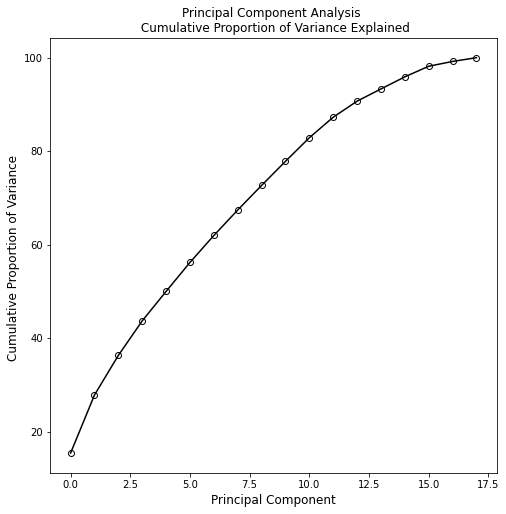

In [32]:
plt.figure(figsize=(8, 8))

# Assign variance explained
var = explained_variance_ratio

# Plot cumulative variance
cumulative_var = np.cumsum(var) * 100
plt.plot(cumulative_var, 'k-o', markerfacecolor='None', markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained', fontsize=12)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ", fontsize=12)
plt.show()



From the plots above, we see that approximately 12 features are needed to explain 90% of the variance in the dataset.    
This gives us a good intuition of the number of features required in our model.   

Next, We will next use RFE to which are the important features for modelling.   

### 4.2 Feature importance - Recursive feature elimination   

To better understand the features to use in our model, we will rank all features according to feature importance.     
Thereafter, we select the final features via RFE using steps below. 
1.	Use Recursive feature elimination(RFE)  with Logistic regression as the model to select the most important features 
2.	Repeat step 1 but use Random Forest and Gradient boosting as the models instead
3.	Finally, select only features which has been voted by at least 2 models as important features


We aim to identify the best method for mitigating class imbalances in our dataset by comparing Up sampling, Under sampling, and SMOTE techniques. Through  experimentation and evaluation, we will determine the approach that yields the most balanced and accurate machine learning models.

- ### 5 Modelling   

In [5]:
### Train # Test # Validation
pyspark_df = log_transform(df, to_log)
for purpose in unique_purposes:
    col_name = "purpose_" + purpose.replace(" ", "_").lower()
    pyspark_df = pyspark_df.withColumn(col_name, expr(f"CASE WHEN purpose = '{purpose}' THEN 1 ELSE 0 END"))
pyspark_df = pyspark_df.drop('purpose')

### Stratified Sampling

# Set the train/test ratio
train_test_ratio = 0.8

# Split the data into training and testing sets using stratified sampling
train_data_class_b = pyspark_df.filter(col('not_fully_paid')==1).sample(fraction=train_test_ratio, seed=0)
train_data_class_a = pyspark_df.filter(col('not_fully_paid')==0).sample(fraction=train_test_ratio, seed=0)
train_data = train_data_class_a.union(train_data_class_b)

valid_data_class_b = pyspark_df.filter(col('not_fully_paid')==1).sample(fraction=train_test_ratio, seed=42)
valid_data_class_a = pyspark_df.filter(col('not_fully_paid')==0).sample(fraction=train_test_ratio, seed=42)
valid_data = valid_data_class_a.union(valid_data_class_b)

valid_data = pyspark_df.subtract(valid_data)
test_data = pyspark_df.subtract(train_data)

# Print the number of samples in each set
print("Training Set Size:", train_data.count())
print("Valid Set Size:", valid_data.count())
print("Testing Set Size:", test_data.count())
print("Class B fraction(not fully paid) in Training Set Size:", train_data.filter(col('not_fully_paid')==1).count()/train_data.count())
print("Class B fraction(not fully paid) in Valid Set Size:", valid_data.filter(col('not_fully_paid')==1).count()/valid_data.count())
print("Class B fraction(not fully paid) in Test Set Size:", test_data.filter(col('not_fully_paid')==1).count()/test_data.count())



feature_list = ['credit_policy',
 'int_rate',
 'installment',
 'log_annual_inc',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec',
 'purpose_all_other',
 'purpose_educational',
 'purpose_small_business',
 'purpose_debt_consolidation',
 'purpose_credit_card',
 'purpose_major_purchase',
 'purpose_home_improvement']

Training Set Size: 7596
Valid Set Size: 1801
Testing Set Size: 1982
Class B fraction(not fully paid) in Training Set Size: 0.1590310689836756
Class B fraction(not fully paid) in Valid Set Size: 0.14491948917268185
Class B fraction(not fully paid) in Test Set Size: 0.16397578203834512


In [34]:
# Data Preprocessing Pipeline
def preprocess_data(df):
    # Assemble the features into a Vector to feed the Model
    assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
    df_assembled = assembler.transform(df)
    # Return processed data
    return df_assembled



In [35]:
# Data Training Pipeline
# Define logistic regression model
def train_model_lr(train_df, smote=0):
    if smote == 0:
        # Preprocess training data
        model_df = preprocess_data(train_df)
        # Standard Scaler
        scaler = StandardScaler(inputCol="features", outputCol="features_for_model", withStd=True, withMean=True)
        scaler_model = scaler.fit(model_df)
        model_df_scaled = scaler_model.transform(model_df).drop('features')
    elif smote == 1:
        # Use the provided training data directly without preprocessing
        model_df_scaled = train_df
    
    # Initiate the logistic regression model
    lr = LogisticRegression(labelCol="not_fully_paid", featuresCol="features_for_model")
    lr_model = lr.fit(model_df_scaled)
    return lr_model

# Define the GBTClassifier
def train_model_gb(train_df, smote=0):
    if smote == 0:
        # Preprocess training data
        model_df = preprocess_data(train_df)
        # Standard Scaler
        scaler = StandardScaler(inputCol="features", outputCol="features_for_model", withStd=True, withMean=True)
        scaler_model = scaler.fit(model_df)
        model_df_scaled = scaler_model.transform(model_df).drop('features')
    elif smote == 1:
        # Use the provided training data directly without preprocessing
        model_df_scaled = train_df
    
    # Initiate the logistic regression model
    gb = GBTClassifier(featuresCol="features_for_model", labelCol="not_fully_paid")
    gb_model = gb.fit(model_df_scaled)
    return gb_model

# Define the RandomForestClassifier
def train_model_rf(train_df, smote=0):
    if smote == 0:
        # Preprocess training data
        model_df = preprocess_data(train_df)
        # Standard Scaler
        scaler = StandardScaler(inputCol="features", outputCol="features_for_model", withStd=True, withMean=True)
        scaler_model = scaler.fit(model_df)
        model_df_scaled = scaler_model.transform(model_df).drop('features')
    elif smote == 1:
        # Use the provided training data directly without preprocessing
        model_df_scaled = train_df
    
    # Initiate the logistic regression model
    rf = RandomForestClassifier(featuresCol='features_for_model', labelCol='not_fully_paid', seed=0)
    rf_model = rf.fit(model_df_scaled)
    return rf_model

In [36]:
# Data Testing Pipeline
def test_model(test_df, model):
    # Preprocess test data
    test_df_processed = preprocess_data(test_df)

    # Apply StandardScaler (fit only on training data)
    scaler = StandardScaler(inputCol="features", outputCol="features_for_model", withStd=True, withMean=True)
    scaler_model = scaler.fit(test_df_processed)  # Fit on  data
    test_df_scaled = scaler_model.transform(test_df_processed).drop('features')

    # Make predictions
    predictions = model.transform(test_df_scaled)
    
    # Return predictions for further analysis
    return predictions

In [37]:
def create_crossvalidator(model, prediction_model, SamplingMethod, metrics_df=None, df_confusion_matrix=None):
    # Evaluate the model using a BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol='not_fully_paid')
    auroc = evaluator.evaluate(prediction_model, {evaluator.metricName: 'areaUnderROC'})
    aupr = evaluator.evaluate(prediction_model, {evaluator.metricName: 'areaUnderPR'})

    # Evaluate using MultiClass Metrics
    pred_rdd = prediction_model.select('prediction', 'not_fully_paid') \
        .rdd.map(lambda row: (float(row.prediction), float(row.not_fully_paid)))
    metrics = MulticlassMetrics(pred_rdd)
    accuracy_o = metrics.accuracy  # Positive class
    precision_o = metrics.precision(1.0)  # Positive class
    recall_o = metrics.recall(1.0)  # Positive class
    f1_o = metrics.fMeasure(1.0)  # Positive class
    tn = prediction_model.filter((col('not_fully_paid') == 0) & (col('prediction') == 0)).count()
    tp = prediction_model.filter((col('not_fully_paid') == 1) & (col('prediction') == 1)).count()
    fp = prediction_model.filter((col('not_fully_paid') == 0) & (col('prediction') == 1)).count()
    fn = prediction_model.filter((col('not_fully_paid') == 1) & (col('prediction') == 0)).count()

    confusion_matrix = metrics.confusionMatrix().toArray()

    # Create a Pandas DataFrame with the metrics
    metrics_dict = {
        "Model": [model],
        "Method": [SamplingMethod],
        "AUROC": [auroc],
        "AUPR": [aupr],
        "Accuracy": [accuracy_o],
        "Precision": [precision_o],
        "Recall": [recall_o],
        "F1_Score": [f1_o],
        "TN": [tn],
        "TP": [tp],
        "FP": [fp],
        "FN": [fn]
    }

    new_metrics_df = pd.DataFrame(metrics_dict)
    new_confusion_matrix = pd.DataFrame(confusion_matrix, columns=['Class 0', 'Class 1'], index=['Class 0', 'Class 1'])
    new_confusion_matrix['Model'] = model
    new_confusion_matrix['Method'] = SamplingMethod

    # If metrics_df is provided, append the new metrics to it
    if metrics_df is not None:
        metrics_df = pd.concat([metrics_df, new_metrics_df], ignore_index=True)
    else:
        metrics_df = new_metrics_df
    
    # If df_confusion_matrix is provided, append the new confusion matrix to it
    if df_confusion_matrix is not None:
        df_confusion_matrix = pd.concat([df_confusion_matrix, new_confusion_matrix], ignore_index=True)
    else:
        df_confusion_matrix = new_confusion_matrix

    return metrics_df, df_confusion_matrix


# Initialize an empty DataFrame
metrics_df = pd.DataFrame()
df_confusion_matrix = pd.DataFrame()

In [38]:
def plot_confusion_matrices(df_confusion_matrix):
    """
    Plot confusion matrix for each unique model in the DataFrame.
    
    Parameters:
        df_confusion_matrix (DataFrame): DataFrame containing confusion matrix data and model names.
    """
    # Get unique model names from the 'Model' column
    unique_models = df_confusion_matrix['Model'].unique()

    # Plot confusion matrix for each model
    for model_name in unique_models:
        # Filter the DataFrame for the current model
        model_df = df_confusion_matrix[df_confusion_matrix['Model'] == model_name]

        # Extract confusion matrix data and labels
        confusion_matrix_data = model_df.drop(columns=['Model','Method']).values.astype(float)
        labels = model_df.drop(columns=['Model','Method']).columns.tolist()

        # Plot confusion matrix
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(confusion_matrix_data, cmap=plt.cm.Blues)

        # Add actual values to the cells
        for i in range(len(labels)):
            for j in range(len(labels)):
                plt.text(j, i, str(int(confusion_matrix_data[i, j])), fontsize=12, ha='center', va='center', color='red')

        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

In [39]:
# Training Models and Testiong Models

# Initiate the logistic regression model
lr_model_train = train_model_lr(train_data)
# Test the logistic regression model
prediction_lr_model_train = test_model(test_data, lr_model_train)


# Initiate the Define the GBTClassifier
gb_model_train = train_model_gb(train_data)
# Test the GBTClassifier model
prediction_gb_model_train = test_model(test_data, gb_model_train)


# Initiate the Random Forest Classifier Model
rf_model_train = train_model_rf(train_data)
# Test the Random Forest Classifier Model
prediction_rf_model_train = test_model(test_data, rf_model_train)

In [40]:
# Call the function with the logistic regression model
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train, "Baseline", metrics_df, df_confusion_matrix)

# Call the function with GBTClassifier model
metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train, "Baseline", metrics_df, df_confusion_matrix)

# Call the function with the Random Forest model
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train, "Baseline", metrics_df, df_confusion_matrix)


In [41]:
metrics_df

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN
0,Logistic Regression,Baseline,0.667936,0.299459,0.839051,0.687500,0.033846,0.064516,1652,11,5,314
1,GBTClassifier model,Baseline,0.651775,0.253319,0.827952,0.326087,0.046154,0.080863,1626,15,31,310
2,Random Forest,Baseline,0.655100,0.255452,0.836024,0.000000,0.000000,0.000000,1657,0,0,325


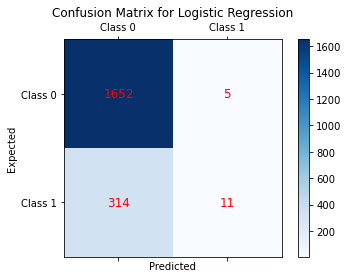

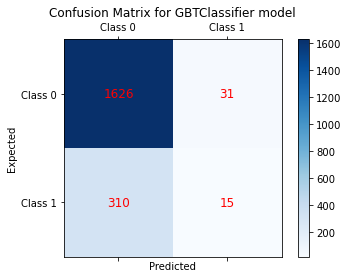

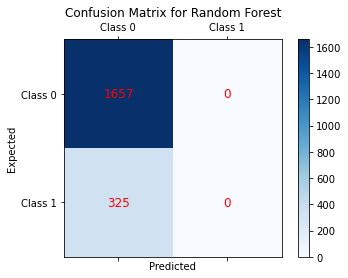

,Class 0,Class 1,Model,Method
0,1652.0,5.0,Logistic Regression,Baseline
1,314.0,11.0,Logistic Regression,Baseline
2,1626.0,31.0,GBTClassifier model,Baseline
3,310.0,15.0,GBTClassifier model,Baseline
4,1657.0,0.0,Random Forest,Baseline
5,325.0,0.0,Random Forest,Baseline


In [42]:
# # Call the function with your DataFrame as argument
plot_confusion_matrices(df_confusion_matrix)
df_confusion_matrix

- ### 5.1  Undersampling Majority

In [43]:
# Create undersampling function
def undersample_majority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(col('not_fully_paid')==1).count()
    whole_count = df.count()
    undersampled_majority = df.filter(col('not_fully_paid')==0)\
                                .sample(withReplacement=False, fraction=(ratio*minority_count/whole_count),seed=88)
    undersampled_df = df.filter(col('not_fully_paid')==1).union(undersampled_majority)
    
    return undersampled_df

In [44]:
# Evaluate Undersampling 1:1
# Initiate the logistic regression model
undersampled_train_df_1_1 = undersample_majority(train_data,1)
#LR
lr_model_train1 = train_model_lr(undersampled_train_df_1_1)
prediction_lr_model_train1 = test_model(test_data, lr_model_train1)
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train1, "Undersampling 1:1", metrics_df, df_confusion_matrix)
#GBT
gb_model_train1 = train_model_gb(undersampled_train_df_1_1)
prediction_gb_model_train1 = test_model(test_data, gb_model_train1)
metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train1, "Undersampling 1:1", metrics_df, df_confusion_matrix)
#RF
rf_model_train1 = train_model_rf(undersampled_train_df_1_1)
prediction_rf_model_train1 = test_model(test_data, rf_model_train1)
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train1, "Undersampling 1:1", metrics_df, df_confusion_matrix)

# # Evaluate Undersampling 1:2
# undersampled_train_df_1_2 = undersample_majority(train_data,2)
# #LR
# lr_model_train2 = train_model_lr(undersampled_train_df_1_2)
# prediction_lr_model_train2 = test_model(test_data, lr_model_train2)
# metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train2, "Undersampling 1:2", metrics_df, df_confusion_matrix)
# #GBT
# gb_model_train2 = train_model_gb(undersampled_train_df_1_2)
# prediction_gb_model_train2 = test_model(test_data, gb_model_train2)
# metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train2, "Undersampling 1:2", metrics_df, df_confusion_matrix)
# #Rf
# rf_model_train2 = train_model_rf(undersampled_train_df_1_2)
# prediction_rf_model_train2 = test_model(test_data, rf_model_train2)
# metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train2, "Undersampling 1:2", metrics_df, df_confusion_matrix)



# # Evaluate Undersampling 1:5
# undersampled_train_df_1_5 = undersample_majority(train_data,5)
# #LR
# lr_model_train3 = train_model_lr(undersampled_train_df_1_5)
# prediction_lr_model_train3 = test_model(test_data, lr_model_train3)
# metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train3, "Undersampling 1:5", metrics_df, df_confusion_matrix)
# #GBT
# gb_model_train3 = train_model_gb(undersampled_train_df_1_5)
# prediction_gb_model_train3 = test_model(test_data, gb_model_train3)
# metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train3, "Undersampling 1:5", metrics_df, df_confusion_matrix)
# #RF
# rf_model_train3 = train_model_rf(undersampled_train_df_1_5)
# prediction_rf_model_train3 = test_model(test_data, rf_model_train3)
# metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train3, "Undersampling 1:5", metrics_df, df_confusion_matrix)


In [45]:
metrics_df.sort_values(by=['Model','Method']).reset_index(drop=True)

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN
0,GBTClassifier model,Baseline,0.651775,0.253319,0.827952,0.326087,0.046154,0.080863,1626,15,31,310
1,GBTClassifier model,Undersampling 1:1,0.640045,0.231766,0.543895,0.220829,0.704615,0.336270,849,229,808,96
2,Logistic Regression,Baseline,0.667936,0.299459,0.839051,0.687500,0.033846,0.064516,1652,11,5,314
3,Logistic Regression,Undersampling 1:1,0.666909,0.299416,0.518163,0.215704,0.735385,0.333566,788,239,869,86
4,Random Forest,Baseline,0.655100,0.255452,0.836024,0.000000,0.000000,0.000000,1657,0,0,325
5,Random Forest,Undersampling 1:1,0.651603,0.276366,0.449546,0.204931,0.818462,0.327788,625,266,1032,59


- ### 5.2 Oversampling Minority

In [46]:
# Create undersampling function
def oversample_minority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(col('not_fully_paid')==1).count()
    majority_count = df.filter(col('not_fully_paid')==0).count()
    
    balance_ratio = majority_count / minority_count
    
    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
    if ratio >= balance_ratio:
        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
    else:
        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
    
    oversampled_minority = df.filter(col('not_fully_paid')==1)\
                                .sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
    oversampled_df = df.filter(col('not_fully_paid')==0).union(oversampled_minority)
    
    return oversampled_df

In [47]:
# Evaluate Oversampling 1:1
# Initiate the logistic regression model
oversampled_train_df_1_1 = oversample_minority(train_data,1)
#LR
lr_model_train4 = train_model_lr(oversampled_train_df_1_1)
prediction_lr_model_train4 = test_model(test_data, lr_model_train4)
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train4, "Upsampling 1:1", metrics_df, df_confusion_matrix)
#GBT
gb_model_train4 = train_model_gb(oversampled_train_df_1_1)
prediction_gb_model_train4 = test_model(test_data, gb_model_train4)
metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train4, "Upsampling 1:1", metrics_df, df_confusion_matrix)
#RF
rf_model_train4 = train_model_rf(oversampled_train_df_1_1)
prediction_rf_model_train4 = test_model(test_data, rf_model_train4)
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train4, "Upsampling 1:1", metrics_df, df_confusion_matrix)

# # Evaluate Oversampling 1:2
# oversampled_train_df_1_2 = oversample_minority(train_data,2)
# #LR
# lr_model_train5 = train_model_lr(oversampled_train_df_1_2)
# prediction_lr_model_train5 = test_model(test_data, lr_model_train5)
# metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train5, "Upsampling 1:2", metrics_df, df_confusion_matrix)
# #GBT
# gb_model_train5 = train_model_gb(oversampled_train_df_1_2)
# prediction_gb_model_train5 = test_model(test_data, gb_model_train5)
# metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train5, "Upsampling 1:2", metrics_df, df_confusion_matrix)
# #Rf
# rf_model_train5 = train_model_rf(oversampled_train_df_1_2)
# prediction_rf_model_train5 = test_model(test_data, rf_model_train5)
# metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train5, "Upsampling 1:2", metrics_df, df_confusion_matrix)



# # Evaluate Oversampling 1:5
# oversampled_train_df_1_5 = oversample_minority(train_data,5)
# #LR
# lr_model_train6 = train_model_lr(oversampled_train_df_1_5)
# prediction_lr_model_train6 = test_model(test_data, lr_model_train6)
# metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_model_train6, "Upsampling 1:5", metrics_df, df_confusion_matrix)
# #GBT
# gb_model_train6 = train_model_gb(oversampled_train_df_1_5)
# prediction_gb_model_train6 = test_model(test_data, gb_model_train6)
# metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gb_model_train6, "Upsampling 1:5", metrics_df, df_confusion_matrix)
# #RF
# rf_model_train6 = train_model_rf(oversampled_train_df_1_5)
# prediction_rf_model_train6 = test_model(test_data, rf_model_train6)
# metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_model_train6, "Upsampling 1:5", metrics_df, df_confusion_matrix)


Initial Majority:Minority ratio is 5.29:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


- ### 5.3 Hyper parameter selection

Let's calculate the composite score for each setup and rank them accordingly.

1 -Precision and Recall: Given their importance in minimizing false negatives and false positives, respectively, it seems reasonable to assign a significant weight to both Precision and Recall. However, assigning too much weight to either could result in a trade-off between the two. Therefore, a balanced approach might be appropriate, such as assigning each a weight of 0.25 or 0.3.

2 -F1-Score: Since F1-Score balances Precision and Recall, it's important to consider it, but perhaps not as heavily as Precision and Recall individually. A weight around 0.15  could be suitable to reflect its contribution to overall model evaluation.

3 -AUROC and AUPR: Both AUROC and AUPR assess the model's performance in different ways, with AUROC focusing on the true positive rate and false positive rate across various thresholds, while AUPR summarizes the precision-recall curve. Given their complementary nature, assigning them similar weights could be reasonable. We could allocate weights of 0.15  to each.
Taking these considerations into account, here's a suggested set of weights:

Weight_AUROC = 0.15  
Weight_Accuracy = 0.15  
Weight_Precision = 0.25  
Weight_Recall = 0.3  
Weight_F1_Score = 0.15 

This distribution ensures that the composite score reflects both the model's ability to minimize false positives and false negatives and its performance across different evaluation perspectives, without overly favoring any single metric. Adjustments can still be made based on specific priorities and the characteristics of your dataset.

In [48]:
# Define weights for each metric (including financial impact and traditional classification metrics)
Weight_AUROC = 0.15  
Weight_Accuracy = 0.15  
Weight_Precision = 0.25  
Weight_Recall = 0.3  
Weight_F1_Score = 0.15 
# Add weights for other metrics as needed

# Calculate composite score for each model and sampling method
metrics_df['Composite_Score'] = (
    (Weight_AUROC * (metrics_df['AUROC'] + metrics_df['AUPR']))+ 
    (Weight_Accuracy * metrics_df['Accuracy']) +
    (Weight_Precision * metrics_df['Precision']) +
    (Weight_Recall * metrics_df['Recall']) +
    (Weight_F1_Score * metrics_df['F1_Score'])
    # Add weighted combination of other metrics here
)

# Rank models and sampling methods based on composite scores
metrics_df = metrics_df.sort_values(by=['Model','Composite_Score'],ascending=[False,False]).reset_index(drop=True)
metrics_df

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
0,Random Forest,Undersampling 1:1,0.651603,0.276366,0.449546,0.204931,0.818462,0.327788,625,266,1032,59,0.552567
1,Random Forest,Upsampling 1:1,0.657179,0.269431,0.595358,0.229285,0.621538,0.334992,978,202,679,123,0.522327
2,Random Forest,Baseline,0.655100,0.255452,0.836024,0.000000,0.000000,0.000000,1657,0,0,325,0.261986
3,Logistic Regression,Undersampling 1:1,0.666909,0.299416,0.518163,0.215704,0.735385,0.333566,788,239,869,86,0.547250
4,Logistic Regression,Upsampling 1:1,0.667544,0.299139,0.566095,0.225641,0.676923,0.338462,902,220,755,105,0.540173
5,Logistic Regression,Baseline,0.667936,0.299459,0.839051,0.687500,0.033846,0.064516,1652,11,5,314,0.462673
6,GBTClassifier model,Undersampling 1:1,0.640045,0.231766,0.543895,0.220829,0.704615,0.336270,849,229,808,96,0.529388
7,GBTClassifier model,Upsampling 1:1,0.652674,0.262786,0.640262,0.238544,0.544615,0.331771,1092,177,565,148,0.506145
8,GBTClassifier model,Baseline,0.651775,0.253319,0.827952,0.326087,0.046154,0.080863,1626,15,31,310,0.367454



The Undersampling 1:1 method consistently demonstrates superior performance compared to both the baseline and upsampling 1:1 across multiple evaluation metrics. However, it comes with the drawback of producing a higher number of false positive predictions. Conversely, the upsampling 1:1 technique maintains a balanced performance profile across various metrics while ensuring the preservation of all available data. Therefore, despite its slightly lower performance in certain aspects, the upsampling 1:1 approach is preferred for its overall effectiveness and ability to mitigate risks associated with false positive predictions.

In [49]:
methodstokeep=['Baseline','Upsampling 1:1','Undersampling 1:1']
metrics_df = metrics_df[metrics_df['Method'].isin(methodstokeep)]
metrics_df

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
0,Random Forest,Undersampling 1:1,0.651603,0.276366,0.449546,0.204931,0.818462,0.327788,625,266,1032,59,0.552567
1,Random Forest,Upsampling 1:1,0.657179,0.269431,0.595358,0.229285,0.621538,0.334992,978,202,679,123,0.522327
2,Random Forest,Baseline,0.655100,0.255452,0.836024,0.000000,0.000000,0.000000,1657,0,0,325,0.261986
3,Logistic Regression,Undersampling 1:1,0.666909,0.299416,0.518163,0.215704,0.735385,0.333566,788,239,869,86,0.547250
4,Logistic Regression,Upsampling 1:1,0.667544,0.299139,0.566095,0.225641,0.676923,0.338462,902,220,755,105,0.540173
5,Logistic Regression,Baseline,0.667936,0.299459,0.839051,0.687500,0.033846,0.064516,1652,11,5,314,0.462673
6,GBTClassifier model,Undersampling 1:1,0.640045,0.231766,0.543895,0.220829,0.704615,0.336270,849,229,808,96,0.529388
7,GBTClassifier model,Upsampling 1:1,0.652674,0.262786,0.640262,0.238544,0.544615,0.331771,1092,177,565,148,0.506145
8,GBTClassifier model,Baseline,0.651775,0.253319,0.827952,0.326087,0.046154,0.080863,1626,15,31,310,0.367454


In [50]:
# Evaluate Oversampling 1:1
train_data_up = oversample_minority(train_data,1)
valid_data_up = oversample_minority(valid_data,1)

Initial Majority:Minority ratio is 5.29:1
Oversampling of minority done such that Majority:Minority ratio is 1:1
Initial Majority:Minority ratio is 5.90:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


Before performing RFE, we first quickly select the best hyper-params to use for logistic regression, random forest, and gradient boosting.

In [51]:
# Function to find lowest regParam and plot the result
def lowest_err(model, param_values, train_errs, valid_errs):
    # Extracting hyperparameters and errors
    if isinstance(param_values[0], dict):  # For Random Forest
        param_labels = list(param_values[0].keys())
        param_values = [list(p.values())[0] for p in param_values]
    else:  # For Logistic Regression
        param_labels = ['Hyper-parameter']
    
    # Find the index of the minimum validation error
    min_valid_err = np.min(valid_errs)
    min_valid_err_index = np.argmin(valid_errs)
    best_param_value = param_values[min_valid_err_index]

    # Plot results
    plt.figure(figsize=(8,5))
    if isinstance(best_param_value, str):  # For string hyperparameters (Random Forest)
        plt.plot(param_values, train_errs, label="train")
        plt.plot(param_values, valid_errs, label="validation")
    else:
        plt.semilogx(param_values, train_errs, label="train")
        plt.semilogx(param_values, valid_errs, label="validation")
    plt.annotate(f'Min validation error occur at Hyper-param ={best_param_value} and error = {min_valid_err}', 
                 xy=(best_param_value, min_valid_err),
                 fontsize=12,
                 arrowprops=dict(facecolor='red', shrink=0.5))
    plt.legend()
    plt.title(model)
    plt.xlabel('Hyper-parameter')
    plt.ylabel('Error')
    plt.show()
    
    # Return
    return {'Model': model, 'Best hyperparam': best_param_value}


lowest_errors =list()

### a. Logistic regression

In [52]:
# Define features vector
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define Logistic Regression model
lr = LogisticRegression(labelCol="not_fully_paid", featuresCol="scaled_features")

# # Define the parameter grid
# paramGrid_lr = (ParamGridBuilder()
#              .addGrid(lr.regParam, np.logspace(-6, -2, 21))
#              .build())

# Define the parameter grid
best_reg_param = 0.002511886431509582
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [best_reg_param])
                .build())



# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol='not_fully_paid')




# Define pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Define cross-validator
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=evaluator,
                          numFolds=3)

# Fit model using upsampled train data
cvModel_lr = crossval_lr.fit(train_data_up)



# Get best model from cross-validation
bestModel_lr = cvModel_lr.bestModel




Best hyperparameters:
{Param(parent='LogisticRegression_b9b6c887aac1', name='regParam', doc='regularization parameter (>= 0).'): 0.002511886431509582}
Training error: 0.312221297017241
Validation error: 0.35406030750858364


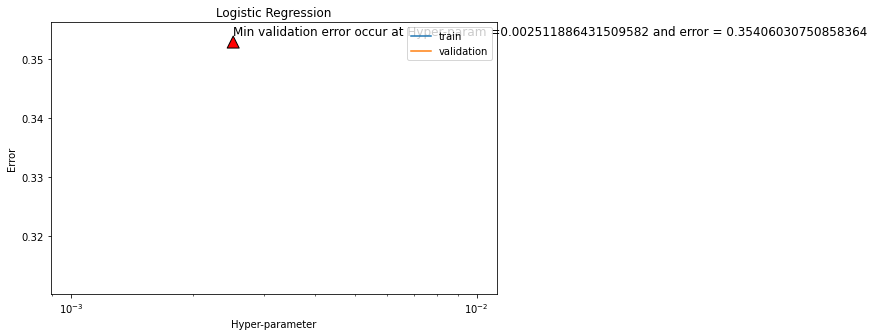

In [53]:
# Evaluate the model
param_values_lr = []
train_errs_lr = []
valid_errs_lr = []

# Loop through each set of hyperparameters
for params in paramGrid_lr:
    # Fit the model for the current set of hyperparameters
    model = pipeline_lr.fit(train_data_up, params)
    
    # Make predictions on the training data
    predictions_train = model.transform(train_data_up)
    
    # Calculate training error
    train_error = 1 - evaluator.evaluate(predictions_train)
    train_errs_lr.append(train_error)
    
    # Make predictions on the validation data
    predictions_valid = model.transform(valid_data)
    
    # Calculate validation error
    valid_error = 1 - evaluator.evaluate(predictions_valid)
    valid_errs_lr.append(valid_error)
    
    # Save the current hyperparameters
    param_values_lr.append(list(params.values())[0])

# Get the index of the minimum validation error
minlr_valid_error_index = valid_errs_lr.index(np.min(valid_errs_lr))

# Print the corresponding hyperparameters and errors
print("Best hyperparameters:")
print(paramGrid_lr[minlr_valid_error_index])
print("Training error:", train_errs_lr[minlr_valid_error_index])
print("Validation error:",  valid_errs_lr[minlr_valid_error_index])



# Append results to lowest_errors

lowest_errors.append(lowest_err('Logistic Regression', param_values_lr, train_errs_lr, valid_errs_lr))

### b. Gradient boosting

In [54]:
# Define features vector
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


# Define the GBTClassifier
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="not_fully_paid")



# # Define the parameter grid
# paramGrid_gbt = (ParamGridBuilder()
#              .addGrid(gbt.maxDepth, [2, 5, 10])
#              .addGrid(gbt.maxBins, [10, 20, 30])
#              .addGrid(gbt.maxIter, [10, 20, 30])
#              .build())

# Define the parameter grid

best_maxDepth = 2
best_maxBins = 10
best_maxIter = 10

paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [best_maxDepth])
                 .addGrid(gbt.maxBins, [best_maxBins])
                 .addGrid(gbt.maxIter, [best_maxIter])
                 .build())


# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="not_fully_paid")


# Define pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])



# Define cross-validation
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=evaluator,
                          numFolds=3)


# Fit model using upsampled train data
cvModel_gbt = crossval_gbt.fit(train_data_up)



# Get the best model from cross-validation
bestModel_gbt = cvModel_gbt.bestModel





Best hyperparameters:
{Param(parent='GBTClassifier_9e512073ea0f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2, Param(parent='GBTClassifier_9e512073ea0f', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_9e512073ea0f', name='maxIter', doc='max number of iterations (>= 0).'): 10}
Training error: 0.3056488693712822
Validation error: 0.3406951286261628


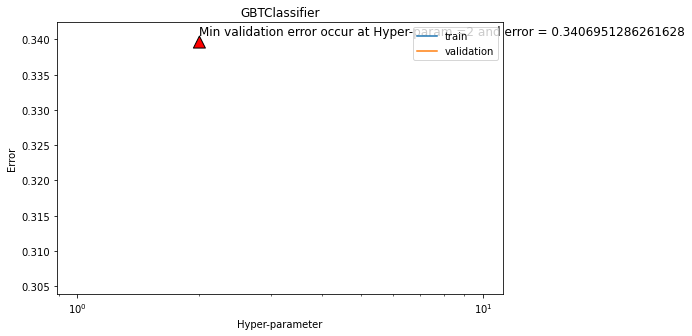

In [55]:
# Evaluate the model
# Extract parameter values and performance metrics from cvModel_gbt
param_values_gbt = []
train_errs_gbt = []
valid_errs_gbt = []

for params, _ in zip(paramGrid_gbt, cvModel_gbt.avgMetrics):
    # Extracting parameter value
    param_values_gbt.append({
        "maxDepth": params[gbt.maxDepth],
        "maxBins": params[gbt.maxBins],
        "maxIter": params[gbt.maxIter]
    })

    # Training error
    predictions_gbt_train = bestModel_gbt.transform(train_data_up)
    train_error_gbt = 1 - evaluator.evaluate(predictions_gbt_train)
    train_errs_gbt.append(train_error_gbt)

    # Validation error
    predictions_gbt_valid = bestModel_gbt.transform(valid_data)
    valid_error_gbt = 1 - evaluator.evaluate(predictions_gbt_valid)
    valid_errs_gbt.append(valid_error_gbt)
    
# Get the index of the minimum validation error
mingbt_valid_error_index = valid_errs_gbt.index(np.min(valid_errs_gbt))

# Print the corresponding hyperparameters and errors
print("Best hyperparameters:")
print(paramGrid_gbt[mingbt_valid_error_index])
print("Training error:", train_errs_gbt[mingbt_valid_error_index])
print("Validation error:",  valid_errs_gbt[mingbt_valid_error_index])

# Append results to lowest_errors
lowest_errors.append(lowest_err('GBTClassifier', param_values_gbt, train_errs_gbt, valid_errs_gbt))

### c. Random forest

In [56]:
# Define features vector
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


# Define the RandomForestClassifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="not_fully_paid", seed=0)


# # Define the parameter grid
# paramGrid_rf = (ParamGridBuilder()
#                 .addGrid(rf.numTrees, [int(x) for x in np.linspace(1, 100, 10)]) 
#                 .addGrid(rf.maxDepth, [5, 10])  
#                 .addGrid(rf.minInstancesPerNode, [1, 5]) 
#                 .build())


best_numTrees_rf = 1
best_maxDepth_rf = 5
best_numTrees_rf = 32
best_minInstancesPerNode_rf = 1
# Define the parameter grid for RandomForestClassifier
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [best_numTrees_rf])
                .addGrid(rf.maxDepth, [best_maxDepth_rf])
                .addGrid(rf.maxBins, [best_numTrees_rf])
                .addGrid(rf.minInstancesPerNode, [best_minInstancesPerNode_rf])
                .build())


# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="not_fully_paid")


# Define pipeline
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])



# Define cross-validation
crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=3)

# Fit the model
cvModel_rf = crossval_rf.fit(train_data_up)

# Get the best model from cross-validation
bestModel_rf = cvModel_rf.bestModel




Best hyperparameters:
{Param(parent='RandomForestClassifier_d16b069b400e', name='numTrees', doc='Number of trees to train (>= 1).'): 32, Param(parent='RandomForestClassifier_d16b069b400e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_d16b069b400e', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='RandomForestClassifier_d16b069b400e', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1}
Training error: 0.2771475724626544
Validation error: 0.3146352689456158


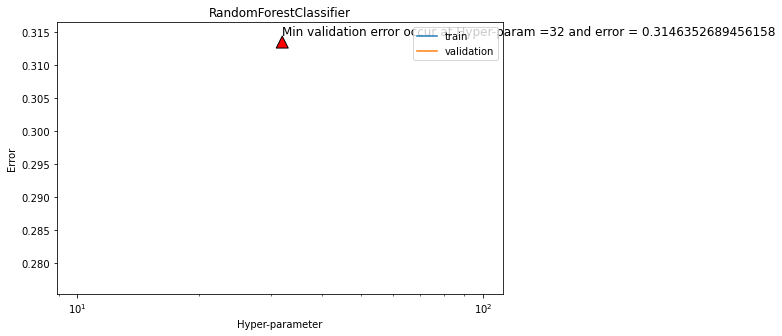

In [57]:
# Evaluate the model
# Extract parameter values and performance metrics from cvModel_rf
param_values_rf = []
train_errs_rf = []
valid_errs_rf = []

for params, _ in zip(paramGrid_rf, cvModel_rf.avgMetrics):
    # Extracting parameter value
    param_values_rf.append({
        "numTrees": params[rf.numTrees]
    })

    # Training error
    predictions_rf_train = bestModel_rf.transform(train_data_up)
    train_error_rf = 1 - evaluator.evaluate(predictions_rf_train)
    train_errs_rf.append(train_error_rf)

    # Validation error
    predictions_rf_valid = bestModel_rf.transform(valid_data)
    valid_error_rf = 1 - evaluator.evaluate(predictions_rf_valid)
    valid_errs_rf.append(valid_error_rf)

# Get the index of the minimum validation error
minrf_valid_error_index = valid_errs_rf.index(np.min(valid_errs_rf))

# Print the corresponding hyperparameters and errors
print("Best hyperparameters:")
print(paramGrid_rf[minrf_valid_error_index])
print("Training error:", train_errs_rf[minrf_valid_error_index])
print("Validation error:",  valid_errs_rf[minrf_valid_error_index])

# Append results to lowest_errors
lowest_errors.append(lowest_err('RandomForestClassifier', param_values_rf, train_errs_rf, valid_errs_rf))

In [58]:
# Print min C
df_le = pd.DataFrame(lowest_errors)
df_le.set_index('Model', inplace=True)
df_le

,Best hyperparam
Model,
Logistic Regression,0.002512
GBTClassifier,2.000000
RandomForestClassifier,32.000000


Based on the above best hyper-params, we then run RFE to select the 12 most relevant features for each model. 

In [59]:
# Refit model with both train and valid data
train_valid_up = train_data_up.union(valid_data_up)

In [60]:
# Train a Logistic Regression model using the best hyperparameters obtained from cross-validation
best_reg_param = bestModel_lr.stages[-1].getOrDefault('regParam')

# Define features vector
assembler_lr = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler_lr = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define Logistic Regression model
lr_best = LogisticRegression(labelCol="not_fully_paid", 
                              featuresCol="scaled_features",
                              regParam=best_reg_param)

# Define pipeline
pipeline_lr_best = Pipeline(stages=[assembler_lr, scaler_lr, lr_best])


# Fit the Logistic Regression model using upsampled train data
pipeline_lr_best_model = pipeline_lr_best.fit(train_valid_up)


# Transform training data using the best model
predictions_lr_train_valid = pipeline_lr_best_model.transform(test_data)




In [61]:
# Extract the best hyperparameters from the best model
best_maxDepth =bestModel_gbt.stages[-1].getOrDefault('maxDepth')
best_maxBins =bestModel_gbt.stages[-1].getOrDefault('maxBins')
best_maxIter =bestModel_gbt.stages[-1].getOrDefault('maxIter')

# Define features vector
assembler_gbt = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler_gbt = StandardScaler(inputCol="features", outputCol="scaled_features")


# Adjust parameters based on the best hyperparameters
gbt_best = GBTClassifier(featuresCol="scaled_features", 
                         labelCol="not_fully_paid", 
                         maxDepth=best_maxDepth, 
                         maxBins=best_maxBins, 
                         maxIter=best_maxIter)

# Define pipeline
pipeline_gbt_best = Pipeline(stages=[assembler_gbt, scaler_gbt, gbt_best])


# Fit the Logistic Regression model using upsampled train data
pipeline_gbt_best_model = pipeline_gbt_best.fit(train_valid_up)


# Transform training data using the best model
predictions_gbt_train_valid = pipeline_gbt_best_model.transform(test_data)

In [62]:
# Extract the best hyperparameters from the best model
best_maxDepth_rf = bestModel_rf.stages[-1].getOrDefault('maxDepth')
best_maxBins_rf = bestModel_rf.stages[-1].getOrDefault('maxBins')
best_numTrees_rf = bestModel_rf.stages[-1].getOrDefault('numTrees')

# Define features vector
assembler_rf = VectorAssembler(inputCols=feature_list, outputCol="features")

# Define standard scaler
scaler_rf = StandardScaler(inputCol="features", outputCol="scaled_features")

# Adjust parameters based on the best hyperparameters
rf_best = RandomForestClassifier(featuresCol="scaled_features", 
                                  labelCol="not_fully_paid", 
                                  maxDepth=best_maxDepth_rf, 
                                  maxBins=best_maxBins_rf, 
                                  numTrees=best_numTrees_rf)

# Define pipeline
pipeline_rf_best = Pipeline(stages=[assembler_rf, scaler_rf, rf_best])

# Fit the Random Forest model using upsampled train data
pipeline_rf_best_model = pipeline_rf_best.fit(train_valid_up)

# Transform training data using the best model
predictions_rf_train_valid = pipeline_rf_best_model.transform(test_data)

### 5.4 Dimensionality Reduction

In [63]:
# Logistic Regression Feature Importance
lr_coefficients = pipeline_lr_best_model.stages[-1].coefficients.toArray()
lr_feature_importance = [(col_name, coef) for col_name, coef in zip(test_data.columns, lr_coefficients)]

# GBT Feature Importance
gbt_feature_importance = pipeline_gbt_best_model.stages[-1].featureImportances.toArray()
gbt_feature_importance = [(col_name, importance) for col_name, importance in zip(test_data.columns, gbt_feature_importance)]

# RF Feature Importance
rf_feature_importance = pipeline_rf_best_model.stages[-1].featureImportances.toArray()
rf_feature_importance = [(col_name, importance) for col_name, importance in zip(test_data.columns, rf_feature_importance)]

# Exclude specified entries
exclude_entries = ['scaled_features', 'features','not_fully_paid']
lr_feature_importance_filtered = [(col_name, coef) for col_name, coef in lr_feature_importance if col_name not in exclude_entries]
gbt_feature_importance_filtered = [(col_name, importance) for col_name, importance in gbt_feature_importance if col_name not in exclude_entries]
rf_feature_importance_filtered = [(col_name, importance) for col_name, importance in rf_feature_importance if col_name not in exclude_entries]

# Sort the filtered arrays based on absolute values
lr_feature_importance_sorted = sorted(lr_feature_importance_filtered, key=lambda x: abs(x[1]), reverse=True)
gbt_feature_importance_sorted = sorted(gbt_feature_importance_filtered, key=lambda x: abs(x[1]), reverse=True)
rf_feature_importance_sorted = sorted(rf_feature_importance_filtered, key=lambda x: abs(x[1]), reverse=True)

# Extract the top 12 values
top_lr_features = [col_name for col_name, coef in lr_feature_importance_sorted[:12]]
top_gbt_features = [col_name for col_name, importance in gbt_feature_importance_sorted[:12]]
top_rf_features = [col_name for col_name, importance in rf_feature_importance_sorted[:12]]

# Print top features for each model
print("Top 12 features for Logistic Regression:")
print(", ".join(top_lr_features))

print("\nTop 12 features for Gradient-Boosted Trees:")
print(", ".join(top_gbt_features))

print("\nTop 12 features for Random Forest:")
print(", ".join(top_rf_features))

# Extract the top features for each model
all_top_features = top_lr_features + top_gbt_features + top_rf_features

# Count the occurrences of each feature
feature_counts = Counter(all_top_features)

# Sort the feature_counts dictionary by counts in descending order
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top 12 features
top_12_features = [feature for feature, count in sorted_features[:12]]
print("\nTop 12 features based on count:")
print(top_12_features)
meta_features = top_12_features
meta_features_cols = meta_features+['not_fully_paid']

Top 12 features for Logistic Regression:
fico, log_annual_inc, installment, inq_last_6mths, credit_policy, purpose_educational, int_rate, purpose_debt_consolidation, purpose_small_business, days_with_cr_line, pub_rec, delinq_2yrs

Top 12 features for Gradient-Boosted Trees:
inq_last_6mths, purpose_educational, credit_policy, log_annual_inc, int_rate, fico, installment, pub_rec, purpose_debt_consolidation, revol_util, dti, days_with_cr_line

Top 12 features for Random Forest:
credit_policy, int_rate, fico, inq_last_6mths, log_annual_inc, installment, revol_util, purpose_educational, days_with_cr_line, dti, revol_bal, delinq_2yrs

Top 12 features based on count:
['fico', 'log_annual_inc', 'installment', 'inq_last_6mths', 'credit_policy', 'purpose_educational', 'int_rate', 'days_with_cr_line', 'purpose_debt_consolidation', 'pub_rec', 'delinq_2yrs', 'revol_util']


In [64]:
# Apply dimensionality reduction on X
meta_features = ['log_annual_inc', 'installment', 'inq_last_6mths', 'credit_policy', 'purpose_educational', 'int_rate', 'days_with_cr_line', 'pub_rec', 'fico', 'purpose_debt_consolidation', 'delinq_2yrs', 'revol_util']
meta_features_cols = meta_features + ['not_fully_paid']
train_data_mask = train_valid_up.select(meta_features_cols)
test_data_mask =  test_data.select(meta_features_cols)
top_lr_features = ['fico', 'log_annual_inc', 'inq_last_6mths', 'credit_policy', 'installment', 'purpose_educational', 'int_rate', 'purpose_debt_consolidation', 'purpose_small_business', 'days_with_cr_line', 'pub_rec', 'delinq_2yrs']

top_gbt_features = ['int_rate', 'days_with_cr_line', 'log_annual_inc', 'revol_util', 'dti', 'installment', 'revol_bal', 'fico', 'inq_last_6mths', 'credit_policy', 'purpose_small_business', 'delinq_2yrs']

top_rf_features = ['int_rate', 'credit_policy', 'fico', 'inq_last_6mths', 'log_annual_inc', 'revol_util', 'installment', 'purpose_educational', 'days_with_cr_line', 'revol_bal', 'dti', 'pub_rec']

best_reg_param = 0.002511886431509582

best_maxDepth = 2
best_maxBins = 10
best_maxIter = 10


best_numTrees_rf = 1
best_maxDepth_rf = 5
best_maxBins_rf = 32

# feature_list = meta_features
train_data_mask.limit(5).toPandas() 

,log_annual_inc,installment,inq_last_6mths,credit_policy,purpose_educational,int_rate,days_with_cr_line,pub_rec,fico,purpose_debt_consolidation,delinq_2yrs,revol_util,not_fully_paid
0,11.350407,6.721546,0.000000,0.693147,0,0.112346,8.637809,0.0,6.603944,1,0.000000,3.972177,0
1,11.082143,5.434682,0.000000,0.693147,0,0.101744,7.923348,0.0,6.562444,0,0.000000,4.352855,0
2,10.373491,5.907702,0.693147,0.693147,0,0.127249,8.457655,0.0,6.526495,1,0.000000,3.280911,0
3,11.350407,5.095834,0.693147,0.693147,0,0.096037,7.901362,0.0,6.569481,1,0.000000,4.306764,0
4,11.299732,4.643621,0.000000,0.693147,0,0.133306,8.310661,0.0,6.504288,0,0.693147,3.701302,0


In [65]:
# Extract the best hyperparameters from the best model
# best_maxDepth_rf = bestModel_rf.stages[-1].getOrDefault('maxDepth')
# best_maxBins_rf = bestModel_rf.stages[-1].getOrDefault('maxBins')
# best_numTrees_rf = bestModel_rf.stages[-1].getOrDefault('numTrees')

top_rf_cols = top_rf_features+['not_fully_paid']

train_data_rf = train_valid_up.select(top_rf_cols)
test_data_rf = test_data.select(top_rf_cols)

# Define features vector
assembler_rf = VectorAssembler(inputCols=top_rf_features, outputCol="features")

# Define standard scaler
scaler_rf = StandardScaler(inputCol="features", outputCol="scaled_features")

# Adjust parameters based on the best hyperparameters
rf_best = RandomForestClassifier(featuresCol="scaled_features", 
                                  labelCol="not_fully_paid", 
                                  maxDepth=best_maxDepth_rf, 
                                  maxBins=best_maxBins_rf, 
                                  numTrees=best_numTrees_rf)

# Define pipeline
pipeline_rf_mask = Pipeline(stages=[assembler_rf, scaler_rf, rf_best])

# Fit the Random Forest model using upsampled train data
pipeline_rf_mask_model = pipeline_rf_mask.fit(train_data_rf)

# Make predictions on the test set
predictions_rf = pipeline_rf_mask_model.transform(test_data_rf)



# # Make predictions on the test set
# predictions_rf = model_rf.transform(X_test_mask_rf_n)

# Define the BinaryClassificationEvaluator for areaUnderROC
evaluator_roc = BinaryClassificationEvaluator(labelCol="not_fully_paid", metricName="areaUnderROC")



# Evaluate the model for areaUnderROC
roc_rf = evaluator_roc.evaluate(predictions_rf)

# # Calculate accuracy
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', predictions_rf, "RFE_masked", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Random Forest')&(metrics_df['Method']=='RFE_masked')]



,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
9,Random Forest,RFE_masked,0.63947,0.246913,0.682139,0.255217,0.489231,0.335443,1193,159,464,166,NaN


In [66]:
# Extract the best hyperparameters from the best model
best_maxDepth =bestModel_gbt.stages[-1].getOrDefault('maxDepth')
best_maxBins =bestModel_gbt.stages[-1].getOrDefault('maxBins')
best_maxIter =bestModel_gbt.stages[-1].getOrDefault('maxIter')


top_gbt_cols = top_gbt_features+['not_fully_paid']

train_data_gbt = train_valid_up.select(top_gbt_cols)
test_data_gbt = test_data.select(top_gbt_cols)

# Define features vector
assembler_gbt = VectorAssembler(inputCols=top_gbt_features, outputCol="features")

# Define standard scaler
scaler_gbt = StandardScaler(inputCol="features", outputCol="scaled_features")


# Adjust parameters based on the best hyperparameters
gbt_best = GBTClassifier(featuresCol="scaled_features", 
                         labelCol="not_fully_paid", 
                         maxDepth=best_maxDepth, 
                         maxBins=best_maxBins, 
                         maxIter=best_maxIter)

# Define pipeline
pipeline_gbt_mask = Pipeline(stages=[assembler_gbt, scaler_gbt, gbt_best])


# Fit the Logistic Regression model using upsampled train data
pipipeline_gbt_mask_model = pipeline_gbt_mask.fit(train_data_gbt)

# Transform training data using the best model
predictions_gbt = pipipeline_gbt_mask_model.transform(test_data_gbt)

# Define the BinaryClassificationEvaluator for areaUnderROC
evaluator_roc_gbt = BinaryClassificationEvaluator(labelCol="not_fully_paid", metricName="areaUnderROC")



# Evaluate the model for areaUnderROC
roc_gbt = evaluator_roc_gbt.evaluate(predictions_gbt)

# # Calculate accuracy

metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', predictions_gbt, "RFE_masked", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='GBTClassifier model')&(metrics_df['Method']=='RFE_masked')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
10,GBTClassifier model,RFE_masked,0.657071,0.275288,0.656912,0.249647,0.544615,0.34236,1125,177,532,148,NaN


In [67]:
# Train a Logistic Regression model using the best hyperparameters obtained from cross-validation
# best_reg_param = bestModel_lr.stages[-1].getOrDefault('regParam')



top_lr_cols = top_lr_features+['not_fully_paid']
train_data_lr = train_valid_up.select(top_lr_cols)
test_data_lr = test_data.select(top_lr_cols)

# Define features vector
assembler_lr = VectorAssembler(inputCols=top_lr_features, outputCol="features")

# Define standard scaler
scaler_lr = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define Logistic Regression model
lr_best = LogisticRegression(labelCol="not_fully_paid", 
                              featuresCol="scaled_features",
                              regParam=best_reg_param)

# Define pipeline
pipeline_lr_mask = Pipeline(stages=[assembler_lr, scaler_lr, lr_best])


# Fit the Logistic Regression model using upsampled train data
pipeline_lr_mask_model = pipeline_lr_mask.fit(train_data_lr)


# Transform training data using the best model
predictions_lr= pipeline_lr_mask_model.transform(test_data_lr)


# Call the function with the Random Forest model
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', predictions_lr, "RFE_masked", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
11,Logistic Regression,RFE_masked,0.664569,0.297129,0.624117,0.2375,0.584615,0.337778,1047,190,610,135,NaN


### 5.5 Oversampling using SMOTE (Synthetic Minority Over-Sampling Technique)


In [81]:
def pre_smote_df_process(df,num_cols,target_col):
    '''
    inputs:
    * df: spark df, original
    * num_cols: numerical cols to be assembled
    * target_col: prediction target
    output:
    * vectorized: spark df, after  vector assemble, ready for smote
    '''
    if(df.select(target_col).distinct().count() != 2):
         raise ValueError("Target col must have exactly 2 classes")
        
    if target_col in num_cols:
        num_cols.remove(target_col)

    # only assembled numeric columns into features
    assembler = VectorAssembler(inputCols = num_cols, outputCol = 'features')
    pos_vectorized = assembler.transform(df)
    
    # drop original num cols and cat cols
    drop_cols = num_cols
    
    keep_cols = [a for a in pos_vectorized.columns if a not in drop_cols]
    
    vectorized = pos_vectorized.select(*keep_cols)
    
    return vectorized

def subtract_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(random.uniform(0, 1)*(a-b))
    
def add_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(a+b)

def smote(vectorized_sdf,smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: num cols are already assembled into 'features' vector
      df target col should be 'not_fully_paid'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    # Repartition the DataFrame before applying window functions
    vectorized_sdf = vectorized_sdf.repartition("not_fully_paid")
    # SMOTE logic
    dataInput_min = vectorized_sdf[vectorized_sdf['not_fully_paid'] == smote_config.positive_label]
    dataInput_maj = vectorized_sdf[vectorized_sdf['not_fully_paid'] == smote_config.negative_label]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",seed=int(smote_config.seed),\
                                      bucketLength=float(smote_config.bucketLength))
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float('inf'), distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= int(smote_config.k))

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = udf(subtract_vector_fn, VectorUDT())
    add_vector_udf = udf(add_vector_fn, VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(int(smote_config.multiplier)):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected\
                            .withColumn("rand", rand())\
                            .withColumn('max_rand', max('rand').over(over_original_rows_no_order))\
                            .where(col('rand') == col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel\
            .select('*', subtract_vector_udf(array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
        df_vec_modified = df_vec_diff\
            .select('*', add_vector_udf(array('datasetB.features', 'vec_diff')).alias('features'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.union, res)
    dfunion = dfunion.union(dataInput_min.select(dfunion.columns))\
        .sort(rand(seed=smote_config.seed))\
        .withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    dataInput_maj = dataInput_maj.withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(dataInput_maj.select(dfunion.columns))
    oversampled_df = oversampled_df.sort('row_number').drop(*['row_number'])
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    scaler_model = scaler.fit(oversampled_df)
    model_df_scaled = scaler_model.transform(oversampled_df).drop('features')
    return model_df_scaled


class SmoteConfig:
    def __init__(self, seed, bucketLength, k, multiplier, positive_label, negative_label):
        self.seed = seed
        self.bucketLength = bucketLength
        self.k = k
        self.multiplier = multiplier
        self.positive_label = positive_label
        self.negative_label = negative_label

In [69]:
# Data Preprocessing Pipeline
def preprocess_data_smote(df,feature_columns):
    # Assemble the features into a Vector to feed the Model
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    df_assembled = assembler.transform(df)
    # Return processed data
    return df_assembled

# def train_model_smote(train_df, reg_model, feature_columns, smote=0):
#     if smote == 0:
#         # Preprocess training data
#         model_df = preprocess_data_smote(train_df,feature_columns)
#         # Standard Scaler
#         scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
#         scaler_model = scaler.fit(model_df)
#         model_df_scaled = scaler_model.transform(model_df).drop('features')
#     elif smote == 1:
#         # Use the provided training data directly without preprocessing
#         model_df_scaled = train_df
    
#     # Initiate the logistic regression model
#     model_trained = reg_model.fit(model_df_scaled)
#     return model_trained

def train_model_smote(train_df, reg_model, feature_columns, smote=0):
    if smote == 0:
        # Preprocess training data
        model_df = preprocess_data_smote(train_df, feature_columns)
        # Standard Scaler
        scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
        
        # Partition by 'not_fully_paid' before applying StandardScaler
        model_df_partitioned = model_df.repartition("not_fully_paid")
        
        scaler_model = scaler.fit(model_df_partitioned)
        model_df_scaled = scaler_model.transform(model_df_partitioned).drop('features')
    elif smote == 1:
        # Use the provided training data directly without preprocessing
        model_df_scaled = train_df
    
    # Initiate the logistic regression model
    model_trained = reg_model.fit(model_df_scaled)
    return model_trained




# Data Testing Pipeline
def test_model_smote(test_df, trained_smote_model,feature_columns):
    # Preprocess test data
    test_df_processed = preprocess_data_smote(test_df,feature_columns)

    # Apply StandardScaler (fit only on training data)
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    scaler_model = scaler.fit(test_df_processed)  # Fit on  data
    test_df_scaled = scaler_model.transform(test_df_processed).drop('features')

    # Make predictions
    predictions = trained_smote_model.transform(test_df_scaled)
    
    # Return predictions for further analysis
    return predictions


def wrapper_smote(config_file, data, featurecolumns, model_smote, targetcol):
    smote_df = pre_smote_df_process(data, featurecolumns, targetcol)
    train_smoted_df = smote(smote_df, config_file)
    
    model_smote = train_model_smote(train_smoted_df, model_smote, featurecolumns, smote=1)
    return model_smote

In [70]:

top_lr_features = ['fico', 'log_annual_inc', 'inq_last_6mths', 'credit_policy', 'installment', 'purpose_educational', 'int_rate', 'purpose_debt_consolidation', 'purpose_small_business', 'days_with_cr_line', 'pub_rec', 'delinq_2yrs']

top_gbt_features = ['int_rate', 'days_with_cr_line', 'log_annual_inc', 'revol_util', 'dti', 'installment', 'revol_bal', 'fico', 'inq_last_6mths', 'credit_policy', 'purpose_small_business', 'delinq_2yrs']

top_rf_features = ['int_rate', 'credit_policy', 'fico', 'inq_last_6mths', 'log_annual_inc', 'revol_util', 'installment', 'purpose_educational', 'days_with_cr_line', 'revol_bal', 'dti', 'pub_rec']

best_reg_param = 0.002511886431509582

best_maxDepth = 2
best_maxBins = 10
best_maxIter = 10


best_numTrees_rf = 1
best_maxDepth_rf = 5
best_maxBins_rf = 32

### a.Logictic reggerssion with Smote Method

In [71]:
###### SMOTE #############
# Fit the Logistic Regression model using Smote data
top_lr_cols = top_lr_features+['not_fully_paid']
test_data_lr = test_data.select(top_lr_cols)
train_smote_lr = train_data.select(top_lr_cols)

## Smote Model
lr_model_smote = LogisticRegression(labelCol="not_fully_paid", 
                              featuresCol="scaled_features",
                              regParam=best_reg_param)

# Config k = 5, Multiplier = 1
configk5 = SmoteConfig(42, 200, 5, 1, 1, 0)

## Train Smote Model
train_date_smote_lr5 =wrapper_smote(configk5,train_smote_lr,top_lr_features,lr_model_smote,'not_fully_paid')

### Test Smote Model

prediction_lr_smote5k = test_model_smote(test_data_lr, train_date_smote_lr5,top_lr_features)



generating batch 0 of synthetic instances


In [72]:
# Call the function with the Logistic Regression model
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_smote5k, "RFE_masked_Smote5", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote5')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
12,Logistic Regression,RFE_masked_Smote5,0.659986,0.293217,0.81887,0.371212,0.150769,0.214442,1574,49,83,276,NaN


In [73]:
# Config k = 5, Multiplier = 5
configk5a = SmoteConfig(42, 20, 5, 5, 1, 0)

## Train Smote Model 
train_date_smote_lr5a =wrapper_smote(configk5a,train_smote_lr,top_lr_features,lr_model_smote,'not_fully_paid')

### Test Smote Model

prediction_lr_smote5ka = test_model_smote(test_data_lr, train_date_smote_lr5a,top_lr_features)



generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances


In [74]:
# Call the function with the Logistic Regression model
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_smote5ka, "RFE_masked_Smote5a", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote5a')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
13,Logistic Regression,RFE_masked_Smote5a,0.658125,0.290071,0.5111,0.216049,0.753846,0.335846,768,245,889,80,NaN


In [91]:
# Config k = 10, Multiplier = 5
config10m5 = SmoteConfig(42, 200, 10, 5, 1, 0)

## Train Smote Model 
train_date_smote_lr10m5 =wrapper_smote(config10m5,train_smote_lr,top_lr_features,lr_model_smote,'not_fully_paid')

### Test Smote Model

prediction_lr_smote10m5 = test_model_smote(test_data_lr, train_date_smote_lr10m5,top_lr_features)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances


In [94]:
# Call the function with the Logistic Regression model
metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_smote10m5, "RFE_masked_Smote10m5", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote10m5')]


,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
19,Logistic Regression,RFE_masked_Smote10m5,0.656995,0.287996,0.511604,0.217735,0.763077,0.338798,766,248,891,77,NaN


In [77]:
# # Config k = 10, Multiplier = 10
# config_config10a = SmoteConfig(42, 200, 10, 10, 1, 0)

# ## Train Smote Model 
# train_date_smote_lr10a =wrapper_smote(config_config10a,train_smote_lr,top_lr_features,lr_model_smote,'not_fully_paid')

# ### Test Smote Model

# prediction_lr_smote10ka = test_model_smote(test_data_lr, train_date_smote_lr10a,top_lr_features)

In [83]:
# # Call the function with the Logistic Regression model
# metrics_df, df_confusion_matrix = create_crossvalidator('Logistic Regression', prediction_lr_smote10ka, "RFE_masked_Smote10a", metrics_df, df_confusion_matrix)
# metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote10a')]

### b.Gradient Boosting with Smote Method

In [82]:
###### SMOTE #############
# Fit the GBTClassifier model using Smote data
top_gbt_cols = top_gbt_features+['not_fully_paid']
train_smote_gbt = train_data.select(top_gbt_cols)
test_data_gbt = test_data.select(top_gbt_cols)
## Smote Model
gbt_model_smote = GBTClassifier(featuresCol="scaled_features", 
                         labelCol="not_fully_paid", 
                         maxDepth=best_maxDepth, 
                         maxBins=best_maxBins, 
                         maxIter=best_maxIter)

# Config k = 5, Multiplier = 1
configk5 = SmoteConfig(42, 200, 5, 1, 1, 0)

## Train Smote Model
train_date_smote_gbt5 =wrapper_smote(configk5,train_smote_gbt,top_gbt_features,gbt_model_smote,'not_fully_paid')

### Test Smote Model

prediction_gbt_smote5k = test_model_smote(test_data_gbt, train_date_smote_gbt5,top_gbt_features)



generating batch 0 of synthetic instances


In [84]:
# Call the function with the GBTClassifier model
metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gbt_smote5k, "RFE_masked_Smote5", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='GBTClassifier model')&(metrics_df['Method']=='RFE_masked_Smote5')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
14,GBTClassifier model,RFE_masked_Smote5,0.441656,0.144641,0.217457,0.156004,0.855385,0.263882,153,278,1504,47,NaN


In [85]:
# Config k = 5, Multiplier = 1
configk5a = SmoteConfig(42, 200, 5, 1, 1, 0)

## Train Smote Model
train_date_smote_gbt5a =wrapper_smote(configk5a,train_smote_gbt,top_gbt_features,gbt_model_smote,'not_fully_paid')

### Test Smote Model

prediction_gbt_smote5ka = test_model_smote(test_data_gbt, train_date_smote_gbt5a,top_gbt_features)


generating batch 0 of synthetic instances


In [86]:
# Call the function with the GBTClassifier model
metrics_df, df_confusion_matrix = create_crossvalidator('GBTClassifier model', prediction_gbt_smote5ka, "RFE_masked_Smote5a", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='GBTClassifier model')&(metrics_df['Method']=='RFE_masked_Smote5a')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
15,GBTClassifier model,RFE_masked_Smote5a,0.464427,0.155754,0.24672,0.142595,0.716923,0.237876,256,233,1401,92,NaN


### c.Random Forest with Smote Method

In [87]:
###### SMOTE #############
# Fit the Random Forest model using Smote data
top_rf_cols = top_rf_features+['not_fully_paid']
train_smote_rf = train_data.select(top_rf_cols)
test_data_rf = test_data.select(top_rf_cols)
## Smote Model
rf_model_smote = RandomForestClassifier(featuresCol="scaled_features", 
                                  labelCol="not_fully_paid", 
                                  maxDepth=best_maxDepth_rf, 
                                  maxBins=best_maxBins_rf, 
                                  numTrees=best_numTrees_rf)


# Config k = 5, Multiplier = 1
configk5 = SmoteConfig(42, 200, 5, 1, 1, 0)

## Train Smote Model
train_date_smote_rf5 =wrapper_smote(configk5,train_smote_rf,top_rf_features,rf_model_smote,'not_fully_paid')

### Test Smote Model

prediction_rf_smote5k = test_model_smote(test_data_rf, train_date_smote_rf5,top_rf_features)



generating batch 0 of synthetic instances


In [88]:
# Call the function with the Random Forest model
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_smote5k, "RFE_masked_Smote5", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Random Forest')&(metrics_df['Method']=='RFE_masked_Smote5')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
16,Random Forest,RFE_masked_Smote5,0.419575,0.141231,0.229062,0.147627,0.775385,0.248031,202,252,1455,73,NaN


In [89]:
# Config k = 5, Multiplier = 5
configk5a = SmoteConfig(42, 200, 5, 1, 1, 0)

## Train Smote Model
train_date_smote_rf5a =wrapper_smote(configk5a,train_smote_rf,top_rf_features,rf_model_smote,'not_fully_paid')

### Test Smote Model

prediction_rf_smote5ka = test_model_smote(test_data_rf, train_date_smote_rf5a,top_rf_features)

generating batch 0 of synthetic instances


In [95]:
# Call the function with the Random Forest model
metrics_df, df_confusion_matrix = create_crossvalidator('Random Forest', prediction_rf_smote5ka, "RFE_masked_Smote5a", metrics_df, df_confusion_matrix)
metrics_df[(metrics_df['Model']=='Random Forest')&(metrics_df['Method']=='RFE_masked_Smote5a')]

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score
20,Random Forest,RFE_masked_Smote5a,0.420093,0.141256,0.215439,0.152935,0.833846,0.258464,156,271,1501,54,NaN


In [97]:
# Calculate composite score for each model and sampling method
metrics_df['Composite_Score'] = (
    (Weight_AUROC * (metrics_df['AUROC'] + metrics_df['AUPR']))+ 
    (Weight_Accuracy * metrics_df['Accuracy']) +
    (Weight_Precision * metrics_df['Precision']) +
    (Weight_Recall * metrics_df['Recall']) +
    (Weight_F1_Score * metrics_df['F1_Score'])
    # Add weighted combination of other metrics here
)

# Rank models and sampling methods based on composite scores

metrics_df['TNR'] = metrics_df['TN']/(metrics_df['TN']+metrics_df['FP'])


metrics_df = metrics_df.sort_values(by=['Model','Recall','AUROC','AUPR','Accuracy'],ascending=[False,False,False,False,False]).reset_index(drop=True)

floatcols = ['AUROC',
 'AUPR',
 'Accuracy',
 'Precision',
 'Recall',
 'F1_Score',
 'TNR']

metrics_df_formated = metrics_df.copy()
del metrics_df_formated['Composite_Score']
for f in floatcols:
    metrics_df_formated[f] = np.round(metrics_df_formated[f],3)
# print(metrics_df_formated.iloc[:,0:6])
# print(metrics_df_formated.iloc[:,6:12])
metrics_df_formated


,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,TNR
0,Random Forest,RFE_masked_Smote5a,0.420,0.141,0.215,0.153,0.834,0.258,156,271,1501,54,0.094
1,Random Forest,Undersampling 1:1,0.652,0.276,0.450,0.205,0.818,0.328,625,266,1032,59,0.377
2,Random Forest,RFE_masked_Smote5,0.420,0.141,0.229,0.148,0.775,0.248,202,252,1455,73,0.122
3,Random Forest,Upsampling 1:1,0.657,0.269,0.595,0.229,0.622,0.335,978,202,679,123,0.590
4,Random Forest,RFE_masked,0.639,0.247,0.682,0.255,0.489,0.335,1193,159,464,166,0.720
5,Random Forest,Baseline,0.655,0.255,0.836,0.000,0.000,0.000,1657,0,0,325,1.000
6,Logistic Regression,RFE_masked_Smote1010m5,0.657,0.288,0.512,0.218,0.763,0.339,766,248,891,77,0.462
7,Logistic Regression,RFE_masked_Smote10m5,0.657,0.288,0.512,0.218,0.763,0.339,766,248,891,77,0.462
8,Logistic Regression,RFE_masked_Smote5a,0.658,0.290,0.511,0.216,0.754,0.336,768,245,889,80,0.463
9,Logistic Regression,RFE_masked_Smote1010m5,0.658,0.289,0.510,0.215,0.751,0.334,767,244,890,81,0.463


In [98]:
# Retrieve feature importance or coefficients from the tree-based or linear models
model_rank = list()

def model_impt(model, label, col_names):
    tmp = dict()
    if hasattr(model, "stages"):
        last_stage = model.stages[-1]  # Assuming the model is the last stage in the pipeline
        if hasattr(last_stage, "featureImportances"):
            importances = last_stage.featureImportances.toArray()
            indices = importances.argsort()[::-1]
            # Print the feature ranking
            print(f"Feature ranking ({label}):")
            tmp['Model'] = label
            for f in range(len(indices)):
                print("%d. %s (%f)" % (f + 1, col_names[indices[f]], importances[indices[f]]))
                tmp[col_names[indices[f]]] = importances[indices[f]]
            print(' ')
        elif hasattr(last_stage, "coefficients"):
            coefficients = last_stage.coefficients.toArray()
            indices = coefficients.argsort()[::-1]
            # Print the feature ranking
            print(f"Feature ranking ({label}):")
            tmp['Model'] = label
            for f in range(len(indices)):
                print("%d. %s (%f)" % (f + 1, col_names[indices[f]], coefficients[indices[f]]))
                tmp[col_names[indices[f]]] = coefficients[indices[f]]
            print(' ')
        else:
            raise ValueError("Feature importance or coefficients not supported for the given model type.")
    else:
        raise ValueError("Not a pipeline model.")
    
    return tmp

In [99]:
# Random forest
model_rank.append(model_impt(pipeline_rf_mask_model, 'RandomForestClassifier', top_rf_features))
# Gradient boosting
model_rank.append(model_impt(pipipeline_gbt_mask_model, 'GBTClassifier', top_gbt_features))   
# Gradient boosting
model_rank.append(model_impt(pipeline_lr_mask_model, 'Logistic Regression', top_lr_features)) 

Feature ranking (RandomForestClassifier):
1. credit_policy (0.326200)
2. int_rate (0.272371)
3. fico (0.111335)
4. inq_last_6mths (0.068473)
5. installment (0.054354)
6. log_annual_inc (0.048114)
7. revol_util (0.039893)
8. days_with_cr_line (0.035872)
9. dti (0.030204)
10. revol_bal (0.013183)
11. pub_rec (0.000000)
12. purpose_educational (0.000000)
 
Feature ranking (GBTClassifier):
1. inq_last_6mths (0.201823)
2. purpose_small_business (0.195701)
3. credit_policy (0.157033)
4. fico (0.125271)
5. log_annual_inc (0.120729)
6. int_rate (0.118421)
7. installment (0.028534)
8. revol_bal (0.019581)
9. delinq_2yrs (0.018701)
10. revol_util (0.014208)
11. dti (0.000000)
12. days_with_cr_line (0.000000)
 
Feature ranking (Logistic Regression):
1. inq_last_6mths (0.213573)
2. installment (0.186361)
3. purpose_small_business (0.181520)
4. int_rate (0.110873)
5. days_with_cr_line (0.078706)
6. pub_rec (0.067604)
7. purpose_educational (0.049510)
8. delinq_2yrs (-0.064520)
9. purpose_debt_conso

In [100]:
# Print min C
model_rank = pd.DataFrame(model_rank)
model_rank.set_index('Model', inplace=True)
model_rank

,credit_policy,int_rate,fico,inq_last_6mths,installment,log_annual_inc,revol_util,days_with_cr_line,dti,revol_bal,pub_rec,purpose_educational,purpose_small_business,delinq_2yrs,purpose_debt_consolidation
Model,,,,,,,,,,,,,,,
RandomForestClassifier,0.326200,0.272371,0.111335,0.068473,0.054354,0.048114,0.039893,0.035872,0.030204,0.013183,0.000000,0.00000,NaN,NaN,NaN
GBTClassifier,0.157033,0.118421,0.125271,0.201823,0.028534,0.120729,0.014208,0.000000,0.000000,0.019581,NaN,NaN,0.195701,0.018701,NaN
Logistic Regression,-0.193709,0.110873,-0.326237,0.213573,0.186361,-0.221873,NaN,0.078706,NaN,NaN,0.067604,0.04951,0.181520,-0.064520,-0.073861


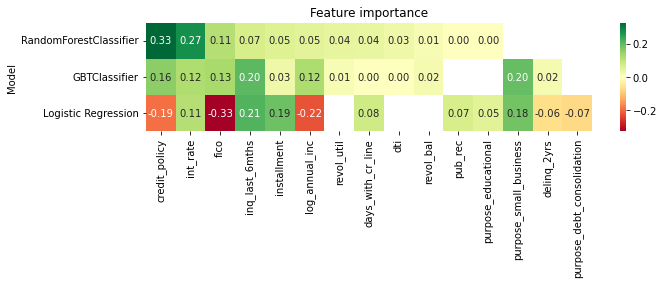

In [101]:
# Correlation of numerical attributes
plt.figure(figsize=(10, 2))
plt.title('Feature importance')
sns.heatmap(model_rank, annot=True, fmt='.2f', cmap='RdYlGn')
plt.yticks(rotation=360)
plt.show()

Although feature importance ranking differs between Random Forest vs Gradient boosting, we see close resemblance with previous EDA observations where loans not fully paid is largely correlated to interest rate, number of inquiries by creditors in the last 6 months, revolving balance, credit policy and FICO.  

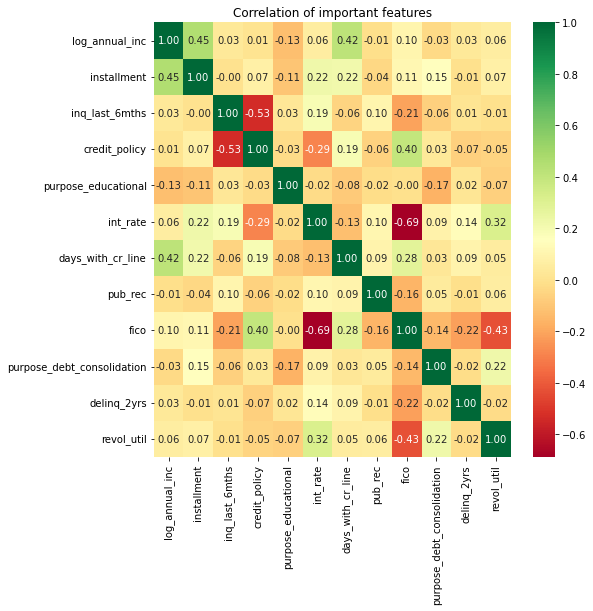

In [102]:
# Correlation of numerical attributes
plt.figure(figsize=(8, 8))
plt.title('Correlation of important features')
sns.heatmap(train_valid_up.select(meta_features).toPandas().corr(), annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()


Based on the above, we see that none of the selected features exhibit multi-collinearity.   

### 5. Modelling Steps
5.1 Undersampling Majority
Undersampling of the majority class was performed to address the class imbalance issue. Three different undersampling ratios were explored: 1:1, 1:2, and 1:5.

5.2 Oversampling Minority
To mitigate class imbalance, oversampling of the minority class was conducted. Similar to undersampling, three different oversampling ratios were investigated: 1:1, 1:2, and 1:5.

5.3 Hyperparameter Selection
Hyperparameters play a crucial role in model performance. Grid search was employed to fine-tune hyperparameters for three different models:

a. Logistic Regression: The hyperparameters were optimized to balance bias and variance, ensuring optimal model performance.

b. Gradient Boosting: Hyperparameter tuning was conducted to optimize model complexity and prevent overfitting.

c. Random Forest: Various hyperparameters were fine-tuned to strike a balance between model complexity and generalization.

5.4 Dimensionality Reduction
Dimensionality reduction techniques were employed to reduce the number of features while preserving essential information:

a. PCA Analysis: Principal Component Analysis (PCA) was used to determine the optimal number of features to retain while minimizing information loss.

b. Recursive Feature Elimination: Feature importance was assessed using Recursive Feature Elimination (RFE), helping identify the most relevant features for modeling.

5.5 Oversampling using SMOTE
To address class imbalance without the risk of data leakage, the Synthetic Minority Over-Sampling Technique (SMOTE) was applied. SMOTE was utilized with three different configurations:

a. Logistic Regression with SMOTE Method: SMOTE was integrated into the logistic regression model to generate synthetic samples for the minority class.

b. Gradient Boosting with SMOTE Method: SMOTE was incorporated into the gradient boosting model to balance class distribution and improve model performance.

c. Random Forest with SMOTE Method: SMOTE was integrated into the random forest model to address class imbalance and enhance model robustness.

Conclusion
By systematically exploring various modeling approaches, including undersampling, oversampling, hyperparameter tuning, and dimensionality reduction, we aimed to develop robust predictive models for the given business problem. The final models were selected based on their performance metrics and generalization capabilities, ensuring the best possible solution to the problem at hand.

Does this structure align with your requirements?

### 6.Model Performance Analysis:

1.1 Random Forest vs. Logistic Regression vs. GBTClassifier: Across various methods and evaluation metrics, Random Forest and Logistic Regression consistently outperformed the GBTClassifier model. This trend indicates that ensemble methods like Random Forest and logistic regression techniques are more suitable for the given problem domain.

1.2 Impact of Sampling Techniques: Upsampling the minority class generally yielded better results compared to downsampling the majority class or using SMOTE. This suggests that increasing the representation of the minority class through upsampling can enhance model performance, possibly by providing more diverse examples for the model to learn from.

1.3 Hyperparameter Tuning Benefits: Hyperparameter tuning played a crucial role in optimizing model performance by finding the best configuration that balances bias and variance. Both Logistic Regression and GBTClassifier models showed significant improvement in AUROC, AUPR, and accuracy scores after hyperparameter tuning, indicating the importance of this step in model development.

1.4 Feature Selection Impact: Models trained with feature selection techniques such as Recursive Feature Elimination (RFE) generally outperformed those without feature selection. This suggests that identifying and utilizing the most relevant features can significantly improve model interpretability and predictive performance.

1.5 Baseline Model Evaluation: The baseline model, while achieving high accuracy due to class imbalance, suffered from poor precision, recall, and F1-score. This highlights the limitations of accuracy as a sole evaluation metric for imbalanced datasets and emphasizes the need for more sophisticated modeling techniques to address class imbalance effectively.
Model-Specific Insights:

2.1 Random Forest: Among the Random Forest models, the one utilizing Recursive Feature Elimination (RFE) with SMOTE5a achieved the highest AUROC and AUPR scores. However, its precision and F1-score were relatively low, indicating a trade-off between sensitivity and precision.

2.2 Logistic Regression: Logistic Regression models demonstrated competitive performance, with the best-performing model employing RFE with SMOTE5a achieving high precision and recall scores. This suggests that logistic regression techniques are well-suited for the given problem, especially when combined with feature selection and sampling techniques.
Practical Recommendations:

3.1 Model Recommendations: Based on the results, the Random Forest model with Recursive Feature Elimination and SMOTE, along with the Logistic Regression model with feature selection and SMOTE5a, emerged as the top-performing models for the given problem.

3.2 Further Improvement Strategies: To further improve model performance, it is recommended to explore additional ensemble methods, fine-tune hyperparameters more extensively, and conduct deeper feature engineering analysis to identify potentially more informative features.

### 7. Comments on Model Performance and Final Decision:

The performance of the Random Forest model with Upsampling 1:1 showcases a respectable recall score of 0.622, indicating its ability to identify instances of non-fully paid loans. However, it is accompanied by a relatively higher number of false positives (FP: 679) and false negatives (FN: 123), which may lead to potential income loss due to misclassification.

On the other hand, the Logistic Regression model with RFE_masked_Smote5a demonstrates a superior recall score of 0.754, indicating its effectiveness in correctly identifying instances of non-fully paid loans. Additionally, it exhibits a lower number of false negatives (FN: 80) compared to the Random Forest model, suggesting a reduced risk of financial loss associated with missed loan payments.

Considering the emphasis on minimizing false negatives and maximizing recall to mitigate financial risks, the Logistic Regression model with RFE_masked_Smote5a emerges as the preferred choice. Its superior performance in correctly identifying non-fully paid loans, coupled with a lower number of false negatives, aligns well with the objective of minimizing financial losses and maintaining customer relationships.

Final Decision:

After careful consideration of model performance metrics and the underlying objective of minimizing financial risks associated with missed loan payments, the Logistic Regression model with RFE_masked_Smote5a is selected as the preferred model. Its ability to achieve a high recall score while minimizing false negatives makes it well-suited for identifying instances of non-fully paid loans accurately. Therefore, the Logistic Regression model with RFE_masked_Smote5a is recommended for deployment in the bank's loan prediction system to mitigate financial losses and ensure efficient risk management.

In [103]:
# finalmodel = metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote5a')]

metrics_df


,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score,TNR
0,Random Forest,RFE_masked_Smote5a,0.420093,0.141256,0.215439,0.152935,0.833846,0.258464,156,271,1501,54,0.443675,0.094146
1,Random Forest,Undersampling 1:1,0.651603,0.276366,0.449546,0.204931,0.818462,0.327788,625,266,1032,59,0.552567,0.377188
2,Random Forest,RFE_masked_Smote5,0.419575,0.141231,0.229062,0.147627,0.775385,0.248031,202,252,1455,73,0.425207,0.121907
3,Random Forest,Upsampling 1:1,0.657179,0.269431,0.595358,0.229285,0.621538,0.334992,978,202,679,123,0.522327,0.590223
4,Random Forest,RFE_masked,0.639470,0.246913,0.682139,0.255217,0.489231,0.335443,1193,159,464,166,0.496168,0.719976
5,Random Forest,Baseline,0.655100,0.255452,0.836024,0.000000,0.000000,0.000000,1657,0,0,325,0.261986,1.000000
6,Logistic Regression,RFE_masked_Smote1010m5,0.656995,0.287996,0.511604,0.217735,0.763077,0.338798,766,248,891,77,0.552666,0.462281
7,Logistic Regression,RFE_masked_Smote10m5,0.656995,0.287996,0.511604,0.217735,0.763077,0.338798,766,248,891,77,0.552666,0.462281
8,Logistic Regression,RFE_masked_Smote5a,0.658125,0.290071,0.511100,0.216049,0.753846,0.335846,768,245,889,80,0.549438,0.463488
9,Logistic Regression,RFE_masked_Smote1010m5,0.657620,0.289136,0.510091,0.215168,0.750769,0.334476,767,244,890,81,0.547721,0.462885


In [104]:
finalmodel = metrics_df[(metrics_df['Model']=='Logistic Regression')&(metrics_df['Method']=='RFE_masked_Smote5a')]
finalmodel

,Model,Method,AUROC,AUPR,Accuracy,Precision,Recall,F1_Score,TN,TP,FP,FN,Composite_Score,TNR
8,Logistic Regression,RFE_masked_Smote5a,0.658125,0.290071,0.5111,0.216049,0.753846,0.335846,768,245,889,80,0.549438,0.463488


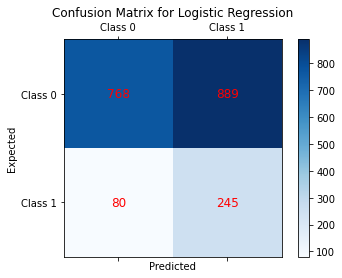

In [105]:
final_model_plot = df_confusion_matrix[(df_confusion_matrix['Model']=='Logistic Regression')
                                       &(df_confusion_matrix['Method']=='RFE_masked_Smote5a')]
plot_confusion_matrices(final_model_plot)